In [24]:
import torch
import os
import numpy as np
import pandas as pd
import polars as pl
from torch.nn import functional as F
from byu.data.io import MultithreadOpencvTomogramLoader
from tqdm import tqdm
import cv2

tomo_loader = MultithreadOpencvTomogramLoader(8)

In [25]:
DATA_DIR = '/home/dangnh36/datasets/.comp/byu/raw/train/'

df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/processed/gt_v2.csv').collect()
df

tomo_id,Z,Y,X,voxel_spacing,ori_num_motors,num_motors,ZA,YA,XA,V,VA,motor_z,motor_y,motor_x,motor_zA,motor_yA,motor_xA,motor_zyx,motor_zyxA
str,i64,i64,i64,f64,i64,i64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,str,str
"""tomo_003acc""",500,1912,1847,6.5,0,0,3250.0,12428.0,12005.5,1765732000,4.8491e11,-1.0,-1.0,-1.0,-6.5,-6.5,-6.5,"""[]""","""[]"""
"""tomo_00e047""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,169.0,546.0,603.0,2636.4,8517.6,9406.8,"""[[169.0, 546.0, 603.0]]""","""[[2636.4, 8517.6, 9406.8]]"""
"""tomo_00e463""",500,924,956,19.7,6,6,9850.0,18202.8,18833.2,441672000,3.3767e12,235.0,403.0,137.0,4629.5,7939.1,2698.9,"""[[235.0, 403.0, 137.0], [243.0…","""[[4629.5, 7939.099999999999, 2…"
"""tomo_01a877""",300,960,928,13.1,1,1,3930.0,12576.0,12156.8,267264000,6.0083e11,147.0,638.0,286.0,1925.7,8357.8,3746.6,"""[[147.0, 638.0, 286.0]]""","""[[1925.7, 8357.8, 3746.6]]"""
"""tomo_02862f""",300,959,928,15.6,1,1,4680.0,14960.4,14476.8,266985600,1.0136e12,101.0,351.0,120.0,1575.6,5475.6,1872.0,"""[[101.0, 351.0, 120.0]]""","""[[1575.6, 5475.599999999999, 1…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""tomo_fe050c""",300,959,928,15.6,1,2,4680.0,14960.4,14476.8,266985600,1.0136e12,138.0,134.0,542.0,2152.8,2090.4,8455.2,"""[[138.0, 134.0, 542.0], [143.1…","""[[2152.7999999999997, 2090.4, …"
"""tomo_fe85f6""",800,928,960,13.1,0,1,10480.0,12156.8,12576.0,712704000,1.6022e12,463.5,903.5,747.0,6071.85,11835.85,9785.7,"""[[463.5, 903.5, 747.0]]""","""[[6071.849999999999, 11835.85,…"
"""tomo_fea6e8""",300,960,928,16.8,0,0,5040.0,16128.0,15590.4,267264000,1.2673e12,-1.0,-1.0,-1.0,-16.8,-16.8,-16.8,"""[]""","""[]"""


In [26]:
df.select(pl.col('Z', 'Y', 'X').mean())

Z,Y,X
f64,f64,f64
415.42284,953.356481,954.842593


In [27]:
df.group_by('num_motors').len().sort('num_motors')

num_motors,len
i64,u32
0,231
1,359
2,35
3,10
4,9
6,3
10,1


In [28]:
(648 - 286) * 4/5

289.6

In [29]:
df.group_by('voxel_spacing').len().sort('voxel_spacing')

voxel_spacing,len
f64,u32
6.5,3
13.1,263
13.2,2
13.3,18
15.6,171
16.1,40
16.8,85
19.2,7
19.3,10


In [31]:
# ORIGINAL WITHOUT ANY INTERPOLATION

ret = {}
DATA_DIR = '/home/dangnh36/datasets/.comp/byu/raw/train/'
TARGET_SPACING = 13.1

tomo_ids = sorted(os.listdir(DATA_DIR))
print('Number of tomos:', len(tomo_ids))
global_hist = None

for row in tqdm(df.iter_rows(named = True), total = len(df)):
    tomo_id = row['tomo_id']
    ori_spacing = row['voxel_spacing']
    tomo_dir = os.path.join(DATA_DIR, tomo_id)
    tomo = tomo_loader.load(tomo_dir)
    ori_shape = tuple(tomo.shape)

    tomo = torch.from_numpy(tomo)
    assert tomo.dtype == torch.uint8
    spaced_shape = tuple(tomo.shape)
    print(tomo_id, ori_shape, '-->', spaced_shape, tomo.dtype)
    hist = torch.bincount(tomo.view(-1), minlength=256)
    assert hist.shape[0] == 256
    # print((tomo == 255).sum())
    # hist = hist / hist.sum()
    hist = hist.cpu().numpy()
    ret[tomo_id] = {
        'ori_shape': ori_shape,
        'spaced_shape': spaced_shape,
        'hist': hist.tolist()
    }

Number of tomos: 648


  0%|                        | 0/648 [00:00<?, ?it/s]

tomo_003acc (500, 1912, 1847) --> (500, 1912, 1847) torch.uint8


  0%|                | 2/648 [00:04<24:11,  2.25s/it]

tomo_00e047 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_00e463 (500, 924, 956) --> (500, 924, 956) torch.uint8


  1%|                | 4/648 [00:10<27:51,  2.60s/it]

tomo_01a877 (300, 960, 928) --> (300, 960, 928) torch.uint8


  1%|                | 5/648 [00:12<25:06,  2.34s/it]

tomo_02862f (300, 959, 928) --> (300, 959, 928) torch.uint8


  1%|▏               | 6/648 [00:14<22:50,  2.13s/it]

tomo_0308c5 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_0333fa (300, 960, 928) --> (300, 960, 928) torch.uint8


  1%|▏               | 8/648 [00:17<20:30,  1.92s/it]

tomo_033ebe (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_03437b (300, 959, 928) --> (300, 959, 928) torch.uint8


  2%|▏              | 10/648 [00:20<18:52,  1.77s/it]

tomo_0363f2 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_040b80 (600, 928, 960) --> (600, 928, 960) torch.uint8


  2%|▎              | 11/648 [00:23<22:21,  2.11s/it]

tomo_049310 (500, 924, 956) --> (500, 924, 956) torch.uint8


  2%|▎              | 12/648 [00:26<23:31,  2.22s/it]

tomo_04d42b (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


  2%|▎              | 13/648 [00:29<25:26,  2.40s/it]

tomo_05b39c (800, 928, 960) --> (800, 928, 960) torch.uint8


  2%|▎              | 15/648 [00:34<26:25,  2.50s/it]

tomo_05df8a (300, 928, 928) --> (300, 928, 928) torch.uint8


  2%|▎              | 16/648 [00:36<23:14,  2.21s/it]

tomo_05f919 (300, 959, 928) --> (300, 959, 928) torch.uint8


  3%|▍              | 17/648 [00:37<20:01,  1.90s/it]

tomo_066095 (300, 960, 928) --> (300, 960, 928) torch.uint8


  3%|▍              | 18/648 [00:38<18:18,  1.74s/it]

tomo_06e11e (300, 960, 928) --> (300, 960, 928) torch.uint8


  3%|▍              | 19/648 [00:40<18:17,  1.74s/it]

tomo_072a16 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_081a2d (300, 959, 928) --> (300, 959, 928) torch.uint8


  3%|▍              | 20/648 [00:42<18:07,  1.73s/it]

tomo_08446f (500, 924, 956) --> (500, 924, 956) torch.uint8


  3%|▍              | 21/648 [00:44<20:02,  1.92s/it]

tomo_087d64 (800, 927, 959) --> (800, 927, 959) torch.uint8


  3%|▌              | 22/648 [00:48<24:59,  2.39s/it]

tomo_08a6d6 (800, 928, 960) --> (800, 928, 960) torch.uint8


  4%|▌              | 23/648 [00:51<28:50,  2.77s/it]

tomo_08bf73 (800, 928, 960) --> (800, 928, 960) torch.uint8


  4%|▌              | 24/648 [00:54<29:06,  2.80s/it]

tomo_098751 (500, 924, 956) --> (500, 924, 956) torch.uint8


  4%|▌              | 25/648 [00:56<27:17,  2.63s/it]

tomo_0a180f (800, 928, 960) --> (800, 928, 960) torch.uint8


  4%|▋              | 27/648 [01:01<24:39,  2.38s/it]

tomo_0a8f05 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_0c2749 (300, 960, 928) --> (300, 960, 928) torch.uint8


  4%|▋              | 29/648 [01:03<18:04,  1.75s/it]

tomo_0c3a99 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_0c3d78 (800, 928, 960) --> (800, 928, 960) torch.uint8


  5%|▋              | 31/648 [01:08<19:44,  1.92s/it]

tomo_0d4c9e (300, 960, 928) --> (300, 960, 928) torch.uint8


  5%|▋              | 32/648 [01:09<16:00,  1.56s/it]

tomo_0da370 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_0de3ee (500, 928, 960) --> (500, 928, 960) torch.uint8


  5%|▊              | 34/648 [01:11<14:36,  1.43s/it]

tomo_0e9757 (300, 960, 928) --> (300, 960, 928) torch.uint8


  5%|▊              | 35/648 [01:12<13:29,  1.32s/it]

tomo_0eb41e (300, 960, 928) --> (300, 960, 928) torch.uint8


  6%|▊              | 36/648 [01:14<12:46,  1.25s/it]

tomo_0eb994 (300, 959, 928) --> (300, 959, 928) torch.uint8


  6%|▊              | 37/648 [01:15<12:34,  1.23s/it]

tomo_0f9df0 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_0fab19 (300, 959, 928) --> (300, 959, 928) torch.uint8


  6%|▉              | 39/648 [01:17<11:30,  1.13s/it]

tomo_0fe63f (300, 960, 928) --> (300, 960, 928) torch.uint8


  6%|▉              | 40/648 [01:18<10:19,  1.02s/it]

tomo_101279 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_10a3bd (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


  6%|▉              | 42/648 [01:21<12:55,  1.28s/it]

tomo_10c564 (300, 960, 928) --> (300, 960, 928) torch.uint8


  7%|▉              | 43/648 [01:22<13:26,  1.33s/it]

tomo_122a02 (300, 959, 928) --> (300, 959, 928) torch.uint8


  7%|█              | 44/648 [01:24<13:28,  1.34s/it]

tomo_122c46 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_12f896 (300, 960, 928) --> (300, 960, 928) torch.uint8


  7%|█              | 46/648 [01:26<12:54,  1.29s/it]

tomo_13484c (300, 928, 928) --> (300, 928, 928) torch.uint8


  7%|█              | 47/648 [01:28<13:46,  1.38s/it]

tomo_134bb0 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_136c8d (500, 924, 956) --> (500, 924, 956) torch.uint8


  8%|█▏             | 49/648 [01:31<15:59,  1.60s/it]

tomo_138018 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_13973d (500, 924, 956) --> (500, 924, 956) torch.uint8


  8%|█▏             | 51/648 [01:35<16:16,  1.64s/it]

tomo_139d9e (300, 959, 928) --> (300, 959, 928) torch.uint8


  8%|█▏             | 52/648 [01:36<15:11,  1.53s/it]

tomo_1446aa (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_146de2 (500, 924, 956) --> (500, 924, 956) torch.uint8


  8%|█▎             | 54/648 [01:39<15:08,  1.53s/it]

tomo_16136a (300, 960, 928) --> (300, 960, 928) torch.uint8


  8%|█▎             | 55/648 [01:40<13:56,  1.41s/it]

tomo_161683 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_16efa8 (300, 960, 928) --> (300, 960, 928) torch.uint8


  9%|█▎             | 56/648 [01:41<12:50,  1.30s/it]

tomo_16fce8 (300, 960, 928) --> (300, 960, 928) torch.uint8


  9%|█▎             | 58/648 [01:44<12:29,  1.27s/it]

tomo_17143f (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_172f08 (800, 928, 960) --> (800, 928, 960) torch.uint8


  9%|█▍             | 60/648 [01:48<15:50,  1.62s/it]

tomo_180bfd (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_183270 (800, 928, 960) --> (800, 928, 960) torch.uint8


 10%|█▍             | 62/648 [01:52<17:22,  1.78s/it]

tomo_191bcb (300, 960, 928) --> (300, 960, 928) torch.uint8


 10%|█▍             | 63/648 [01:54<15:45,  1.62s/it]

tomo_19a313 (300, 960, 928) --> (300, 960, 928) torch.uint8


 10%|█▍             | 64/648 [01:55<13:57,  1.43s/it]

tomo_19a4fd (300, 960, 928) --> (300, 960, 928) torch.uint8


 10%|█▌             | 65/648 [01:56<12:34,  1.29s/it]

tomo_1ab322 (300, 960, 928) --> (300, 960, 928) torch.uint8


 10%|█▌             | 66/648 [01:57<12:29,  1.29s/it]

tomo_1af88d (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_1b82d1 (500, 924, 956) --> (500, 924, 956) torch.uint8


 10%|█▌             | 67/648 [01:59<14:02,  1.45s/it]

tomo_1c2534 (800, 927, 959) --> (800, 927, 959) torch.uint8


 11%|█▌             | 69/648 [02:01<12:59,  1.35s/it]

tomo_1c38fd (300, 960, 928) --> (300, 960, 928) torch.uint8


 11%|█▌             | 70/648 [02:02<11:01,  1.14s/it]

tomo_1c75ac (300, 960, 928) --> (300, 960, 928) torch.uint8


 11%|█▋             | 71/648 [02:03<10:17,  1.07s/it]

tomo_1cc887 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_1da097 (500, 928, 960) --> (500, 928, 960) torch.uint8


 11%|█▋             | 72/648 [02:04<10:46,  1.12s/it]

tomo_1da0da (800, 928, 960) --> (800, 928, 960) torch.uint8


 11%|█▋             | 73/648 [02:07<15:57,  1.67s/it]

tomo_1dc5f9 (500, 924, 956) --> (500, 924, 956) torch.uint8


 12%|█▋             | 75/648 [02:10<15:07,  1.58s/it]

tomo_1e9980 (300, 960, 928) --> (300, 960, 928) torch.uint8


 12%|█▊             | 76/648 [02:11<13:38,  1.43s/it]

tomo_1efc28 (300, 959, 928) --> (300, 959, 928) torch.uint8


 12%|█▊             | 77/648 [02:13<13:01,  1.37s/it]

tomo_1f0e78 (300, 959, 928) --> (300, 959, 928) torch.uint8


 12%|█▊             | 78/648 [02:14<12:26,  1.31s/it]

tomo_1fb6a7 (300, 960, 928) --> (300, 960, 928) torch.uint8


 12%|█▊             | 79/648 [02:15<11:23,  1.20s/it]

tomo_20a9ed (300, 960, 928) --> (300, 960, 928) torch.uint8


 12%|█▊             | 80/648 [02:16<11:11,  1.18s/it]

tomo_210371 (300, 960, 928) --> (300, 960, 928) torch.uint8


 12%|█▉             | 81/648 [02:17<10:33,  1.12s/it]

tomo_221a47 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_221c8e (500, 928, 928) --> (500, 928, 928) torch.uint8


 13%|█▉             | 83/648 [02:20<11:08,  1.18s/it]

tomo_225d8f (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_226cd8 (500, 928, 960) --> (500, 928, 960) torch.uint8


 13%|█▉             | 84/648 [02:21<13:20,  1.42s/it]

tomo_22976c (500, 928, 960) --> (500, 928, 960) torch.uint8


 13%|█▉             | 85/648 [02:24<15:13,  1.62s/it]

tomo_229f0a (500, 960, 928) --> (500, 960, 928) torch.uint8


 13%|██             | 87/648 [02:27<14:27,  1.55s/it]

tomo_23a8e8 (300, 960, 928) --> (300, 960, 928) torch.uint8


 14%|██             | 88/648 [02:28<13:20,  1.43s/it]

tomo_23c8a4 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_23ce49 (300, 959, 928) --> (300, 959, 928) torch.uint8


 14%|██             | 89/648 [02:29<12:44,  1.37s/it]

tomo_247826 (500, 960, 928) --> (500, 960, 928) torch.uint8


 14%|██             | 91/648 [02:32<13:17,  1.43s/it]

tomo_24795a (300, 960, 928) --> (300, 960, 928) torch.uint8


 14%|██▏            | 92/648 [02:33<12:28,  1.35s/it]

tomo_2483bb (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_24a095 (800, 928, 960) --> (800, 928, 960) torch.uint8


 15%|██▏            | 94/648 [02:37<14:15,  1.54s/it]

tomo_24fda8 (300, 960, 928) --> (300, 960, 928) torch.uint8


 15%|██▏            | 95/648 [02:38<13:22,  1.45s/it]

tomo_256717 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_25780f (300, 960, 928) --> (300, 960, 928) torch.uint8


 15%|██▏            | 97/648 [02:41<12:05,  1.32s/it]

tomo_2645a0 (300, 960, 928) --> (300, 960, 928) torch.uint8


 15%|██▎            | 98/648 [02:42<11:36,  1.27s/it]

tomo_278194 (300, 960, 928) --> (300, 960, 928) torch.uint8


 15%|██▎            | 99/648 [02:43<11:06,  1.21s/it]

tomo_285454 (300, 956, 924) --> (300, 956, 924) torch.uint8


 15%|██▏           | 100/648 [02:44<11:13,  1.23s/it]

tomo_285d15 (300, 960, 928) --> (300, 960, 928) torch.uint8


 16%|██▏           | 101/648 [02:46<11:43,  1.29s/it]

tomo_288d4f (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_28f9c1 (500, 924, 956) --> (500, 924, 956) torch.uint8


 16%|██▏           | 103/648 [02:49<12:29,  1.37s/it]

tomo_2a6091 (300, 960, 928) --> (300, 960, 928) torch.uint8


 16%|██▏           | 104/648 [02:50<11:29,  1.27s/it]

tomo_2a6ca2 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_2a89bb (800, 928, 960) --> (800, 928, 960) torch.uint8


 16%|██▎           | 106/648 [02:54<13:45,  1.52s/it]

tomo_2acf68 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_2aeb29 (800, 927, 959) --> (800, 927, 959) torch.uint8


 17%|██▎           | 108/648 [02:57<14:50,  1.65s/it]

tomo_2b3cdf (300, 960, 928) --> (300, 960, 928) torch.uint8


 17%|██▎           | 109/648 [02:59<13:44,  1.53s/it]

tomo_2b996c (300, 960, 928) --> (300, 960, 928) torch.uint8


 17%|██▍           | 110/648 [03:00<12:15,  1.37s/it]

tomo_2bb588 (300, 960, 928) --> (300, 960, 928) torch.uint8


 17%|██▍           | 111/648 [03:01<11:31,  1.29s/it]

tomo_2c607f (300, 960, 928) --> (300, 960, 928) torch.uint8


 17%|██▍           | 112/648 [03:02<11:07,  1.25s/it]

tomo_2c8ea2 (300, 959, 928) --> (300, 959, 928) torch.uint8


 17%|██▍           | 113/648 [03:03<10:41,  1.20s/it]

tomo_2c9da1 (300, 960, 928) --> (300, 960, 928) torch.uint8


 18%|██▍           | 114/648 [03:04<10:21,  1.16s/it]

tomo_2c9f35 (300, 960, 928) --> (300, 960, 928) torch.uint8


 18%|██▍           | 115/648 [03:05<10:08,  1.14s/it]

tomo_2cace2 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_2daaee (500, 924, 956) --> (500, 924, 956) torch.uint8


 18%|██▌           | 117/648 [03:08<11:15,  1.27s/it]

tomo_2dcd5c (300, 960, 928) --> (300, 960, 928) torch.uint8


 18%|██▌           | 118/648 [03:09<10:29,  1.19s/it]

tomo_2dd6bd (300, 928, 928) --> (300, 928, 928) torch.uint8


 18%|██▌           | 119/648 [03:10<10:20,  1.17s/it]

tomo_2e1f4c (300, 959, 928) --> (300, 959, 928) torch.uint8


 19%|██▌           | 120/648 [03:11<09:41,  1.10s/it]

tomo_2f3261 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_2fb12d (300, 960, 928) --> (300, 960, 928) torch.uint8


 19%|██▋           | 122/648 [03:13<09:28,  1.08s/it]

tomo_2fc82d (300, 960, 928) --> (300, 960, 928) torch.uint8


 19%|██▋           | 123/648 [03:14<09:22,  1.07s/it]

tomo_305c97 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_307f33 (800, 928, 960) --> (800, 928, 960) torch.uint8


 19%|██▋           | 125/648 [03:18<12:31,  1.44s/it]

tomo_30b580 (300, 928, 928) --> (300, 928, 928) torch.uint8


 19%|██▋           | 126/648 [03:19<11:32,  1.33s/it]

tomo_30d4e5 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_317656 (300, 960, 928) --> (300, 960, 928) torch.uint8


 20%|██▋           | 127/648 [03:20<10:56,  1.26s/it]

tomo_3183d2 (300, 959, 928) --> (300, 959, 928) torch.uint8


 20%|██▊           | 128/648 [03:22<10:42,  1.24s/it]

tomo_319f79 (500, 928, 960) --> (500, 928, 960) torch.uint8


 20%|██▊           | 130/648 [03:25<10:59,  1.27s/it]

tomo_3264bc (300, 928, 928) --> (300, 928, 928) torch.uint8


 20%|██▊           | 131/648 [03:25<10:04,  1.17s/it]

tomo_32aaa7 (300, 960, 928) --> (300, 960, 928) torch.uint8


 20%|██▊           | 132/648 [03:27<10:01,  1.17s/it]

tomo_331130 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_35ec84 (800, 928, 960) --> (800, 928, 960) torch.uint8


 21%|██▉           | 134/648 [03:31<13:32,  1.58s/it]

tomo_369cce (300, 960, 928) --> (300, 960, 928) torch.uint8


 21%|██▉           | 135/648 [03:32<12:31,  1.46s/it]

tomo_37076e (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_372690 (800, 928, 960) --> (800, 928, 960) torch.uint8


 21%|██▉           | 137/648 [03:36<13:59,  1.64s/it]

tomo_372a5c (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_374ca7 (800, 928, 960) --> (800, 928, 960) torch.uint8


 21%|███           | 139/648 [03:40<15:06,  1.78s/it]

tomo_375513 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_378f43 (300, 960, 928) --> (300, 960, 928) torch.uint8


 22%|███           | 140/648 [03:41<13:33,  1.60s/it]

tomo_37c426 (600, 960, 928) --> (600, 960, 928) torch.uint8


 22%|███           | 141/648 [03:48<26:20,  3.12s/it]

tomo_37dd38 (500, 924, 956) --> (500, 924, 956) torch.uint8


 22%|███           | 142/648 [03:50<23:57,  2.84s/it]

tomo_381add (500, 924, 956) --> (500, 924, 956) torch.uint8


 22%|███           | 144/648 [03:53<18:14,  2.17s/it]

tomo_385eb6 (300, 960, 928) --> (300, 960, 928) torch.uint8


 22%|███▏          | 145/648 [03:55<15:38,  1.87s/it]

tomo_38c2a6 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_38d285 (800, 928, 960) --> (800, 928, 960) torch.uint8


 23%|███▏          | 147/648 [03:59<15:20,  1.84s/it]

tomo_399bd9 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_39b15b (500, 924, 956) --> (500, 924, 956) torch.uint8


 23%|███▏          | 148/648 [04:01<15:27,  1.86s/it]

tomo_3a0914 (800, 928, 960) --> (800, 928, 960) torch.uint8


 23%|███▏          | 150/648 [04:11<26:38,  3.21s/it]

tomo_3a3519 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_3a6a9d (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 23%|███▎          | 151/648 [04:13<23:35,  2.85s/it]

tomo_3a8480 (500, 924, 956) --> (500, 924, 956) torch.uint8


 24%|███▎          | 153/648 [04:16<17:16,  2.09s/it]

tomo_3b1cc9 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_3b7a22 (800, 928, 960) --> (800, 928, 960) torch.uint8


 24%|███▎          | 154/648 [04:20<21:21,  2.59s/it]

tomo_3b8291 (500, 924, 956) --> (500, 924, 956) torch.uint8


 24%|███▎          | 156/648 [04:23<17:32,  2.14s/it]

tomo_3b83c7 (300, 960, 928) --> (300, 960, 928) torch.uint8


 24%|███▍          | 157/648 [04:25<15:45,  1.93s/it]

tomo_3c6038 (300, 959, 928) --> (300, 959, 928) torch.uint8


 24%|███▍          | 158/648 [04:26<14:04,  1.72s/it]

tomo_3e6ead (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_3e7407 (500, 924, 956) --> (500, 924, 956) torch.uint8


 25%|███▍          | 160/648 [04:30<14:25,  1.77s/it]

tomo_3e7783 (300, 960, 928) --> (300, 960, 928) torch.uint8


 25%|███▍          | 161/648 [04:31<13:41,  1.69s/it]

tomo_3eb9c8 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_401341 (300, 960, 928) --> (300, 960, 928) torch.uint8


 25%|███▌          | 162/648 [04:33<13:13,  1.63s/it]

tomo_4077d8 (300, 928, 928) --> (300, 928, 928) torch.uint8


 25%|███▌          | 163/648 [04:34<12:34,  1.56s/it]

tomo_40b215 (500, 924, 956) --> (500, 924, 956) torch.uint8


 25%|███▌          | 165/648 [04:38<13:27,  1.67s/it]

tomo_4102f1 (300, 928, 928) --> (300, 928, 928) torch.uint8


 26%|███▌          | 166/648 [04:40<13:25,  1.67s/it]

tomo_412d88 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_417e5f (300, 960, 928) --> (300, 960, 928) torch.uint8


 26%|███▌          | 167/648 [04:41<12:23,  1.55s/it]

tomo_41ea80 (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 26%|███▋          | 169/648 [04:45<14:01,  1.76s/it]

tomo_423d52 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_444829 (300, 928, 928) --> (300, 928, 928) torch.uint8


 26%|███▋          | 171/648 [04:48<13:00,  1.64s/it]

tomo_4469a7 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_4555b6 (500, 924, 956) --> (500, 924, 956) torch.uint8


 27%|███▋          | 173/648 [04:52<14:06,  1.78s/it]

tomo_455dcd (300, 960, 928) --> (300, 960, 928) torch.uint8


 27%|███▊          | 174/648 [04:54<13:56,  1.76s/it]

tomo_46250a (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_464108 (800, 928, 928) --> (800, 928, 928) torch.uint8


 27%|███▊          | 176/648 [05:00<18:01,  2.29s/it]

tomo_466489 (300, 960, 928) --> (300, 960, 928) torch.uint8


 27%|███▊          | 177/648 [05:01<16:18,  2.08s/it]

tomo_47ac94 (300, 960, 928) --> (300, 960, 928) torch.uint8


 27%|███▊          | 178/648 [05:03<14:46,  1.89s/it]

tomo_47c399 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_47d380 (800, 928, 960) --> (800, 928, 960) torch.uint8


 28%|███▊          | 179/648 [05:07<19:02,  2.44s/it]

tomo_48dc93 (500, 924, 956) --> (500, 924, 956) torch.uint8


 28%|███▉          | 181/648 [05:10<15:51,  2.04s/it]

tomo_4925ee (300, 960, 928) --> (300, 960, 928) torch.uint8


 28%|███▉          | 182/648 [05:12<14:26,  1.86s/it]

tomo_493bea (300, 960, 928) --> (300, 960, 928) torch.uint8


 28%|███▉          | 183/648 [05:13<12:57,  1.67s/it]

tomo_49725c (300, 959, 928) --> (300, 959, 928) torch.uint8


 28%|███▉          | 184/648 [05:14<11:49,  1.53s/it]

tomo_499ee0 (300, 960, 928) --> (300, 960, 928) torch.uint8


 29%|███▉          | 185/648 [05:15<10:04,  1.31s/it]

tomo_49f4ee (300, 928, 928) --> (300, 928, 928) torch.uint8


 29%|████          | 186/648 [05:16<09:45,  1.27s/it]

tomo_4b124b (300, 960, 928) --> (300, 960, 928) torch.uint8


 29%|████          | 187/648 [05:17<09:48,  1.28s/it]

tomo_4b59a2 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_4baff0 (500, 924, 956) --> (500, 924, 956) torch.uint8


 29%|████          | 188/648 [05:19<11:55,  1.55s/it]

tomo_4c1ca8 (800, 928, 960) --> (800, 928, 960) torch.uint8


 29%|████          | 190/648 [05:24<13:23,  1.75s/it]

tomo_4c2e4e (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_4d528f (800, 928, 960) --> (800, 928, 960) torch.uint8


 29%|████▏         | 191/648 [05:27<16:07,  2.12s/it]

tomo_4e1b18 (500, 924, 956) --> (500, 924, 956) torch.uint8


 30%|████▏         | 193/648 [05:30<13:01,  1.72s/it]

tomo_4e38b8 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_4e3e37 (800, 928, 960) --> (800, 928, 960) torch.uint8


 30%|████▏         | 194/648 [05:32<15:38,  2.07s/it]

tomo_4e41c2 (800, 927, 959) --> (800, 927, 959) torch.uint8


 30%|████▏         | 195/648 [05:36<18:25,  2.44s/it]

tomo_4e478f (300, 959, 928) --> (300, 959, 928) torch.uint8


 30%|████▏         | 196/648 [05:37<15:55,  2.11s/it]

tomo_4ed9de (300, 960, 928) --> (300, 960, 928) torch.uint8


 31%|████▎         | 198/648 [05:40<12:37,  1.68s/it]

tomo_4ee35e (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_4f379f (300, 959, 928) --> (300, 959, 928) torch.uint8


 31%|████▎         | 200/648 [05:42<10:46,  1.44s/it]

tomo_4f5a7b (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_507b7a (500, 928, 960) --> (500, 928, 960) torch.uint8


 31%|████▎         | 201/648 [05:44<12:03,  1.62s/it]

tomo_50cbd9 (800, 928, 960) --> (800, 928, 960) torch.uint8


 31%|████▎         | 202/648 [05:47<15:38,  2.10s/it]

tomo_50f0bf (500, 924, 956) --> (500, 924, 956) torch.uint8


 31%|████▍         | 204/648 [05:51<13:12,  1.78s/it]

tomo_510f4e (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_512f98 (800, 928, 960) --> (800, 928, 960) torch.uint8


 32%|████▍         | 206/648 [05:55<13:34,  1.84s/it]

tomo_513010 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_516cdd (300, 959, 928) --> (300, 959, 928) torch.uint8


 32%|████▍         | 208/648 [05:57<10:42,  1.46s/it]

tomo_517f70 (300, 928, 928) --> (300, 928, 928) torch.uint8


 32%|████▌         | 209/648 [05:58<09:58,  1.36s/it]

tomo_518a1f (300, 960, 928) --> (300, 960, 928) torch.uint8


 32%|████▌         | 210/648 [05:59<08:37,  1.18s/it]

tomo_51a47f (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_51a77e (500, 928, 960) --> (500, 928, 960) torch.uint8


 33%|████▌         | 211/648 [06:00<08:46,  1.20s/it]

tomo_5308e8 (800, 928, 960) --> (800, 928, 960) torch.uint8


 33%|████▌         | 212/648 [06:02<10:53,  1.50s/it]

tomo_532d49 (300, 960, 928) --> (300, 960, 928) torch.uint8


 33%|████▌         | 213/648 [06:03<09:24,  1.30s/it]

tomo_539259 (300, 960, 928) --> (300, 960, 928) torch.uint8


 33%|████▌         | 214/648 [06:04<08:24,  1.16s/it]

tomo_53c71b (800, 928, 960) --> (800, 928, 960) torch.uint8


 33%|████▋         | 216/648 [06:08<10:14,  1.42s/it]

tomo_53e048 (300, 960, 928) --> (300, 960, 928) torch.uint8


 33%|████▋         | 217/648 [06:08<08:59,  1.25s/it]

tomo_54e1a7 (300, 928, 928) --> (300, 928, 928) torch.uint8


 34%|████▋         | 218/648 [06:10<09:19,  1.30s/it]

tomo_556257 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_568537 (300, 960, 928) --> (300, 960, 928) torch.uint8


 34%|████▋         | 219/648 [06:11<09:13,  1.29s/it]

tomo_569981 (800, 928, 928) --> (800, 928, 928) torch.uint8


 34%|████▊         | 221/648 [06:16<12:04,  1.70s/it]

tomo_56b9a3 (300, 928, 928) --> (300, 928, 928) torch.uint8


 34%|████▊         | 222/648 [06:17<10:59,  1.55s/it]

tomo_57592d (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_5764d6 (500, 928, 960) --> (500, 928, 960) torch.uint8


 35%|████▊         | 224/648 [06:20<10:58,  1.55s/it]

tomo_57c814 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_5984bf (800, 928, 960) --> (800, 928, 960) torch.uint8


 35%|████▊         | 225/648 [06:23<14:22,  2.04s/it]

tomo_59b470 (300, 960, 928) --> (300, 960, 928) torch.uint8


 35%|████▉         | 226/648 [06:25<12:42,  1.81s/it]

tomo_5b087f (300, 959, 928) --> (300, 959, 928) torch.uint8


 35%|████▉         | 228/648 [06:27<10:07,  1.45s/it]

tomo_5b34b2 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_5b359d (800, 928, 960) --> (800, 928, 960) torch.uint8


 35%|████▉         | 229/648 [06:30<13:25,  1.92s/it]

tomo_5b8db4 (800, 928, 960) --> (800, 928, 960) torch.uint8


 35%|████▉         | 230/648 [06:34<17:09,  2.46s/it]

tomo_5ba0cf (500, 924, 956) --> (500, 924, 956) torch.uint8


 36%|████▉         | 231/648 [06:36<16:44,  2.41s/it]

tomo_5bb31c (800, 928, 928) --> (800, 928, 928) torch.uint8


 36%|█████         | 232/648 [06:39<18:42,  2.70s/it]

tomo_5d01e8 (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 36%|█████         | 233/648 [06:42<18:00,  2.60s/it]

tomo_5d4c65 (500, 928, 960) --> (500, 928, 960) torch.uint8


 36%|█████         | 235/648 [06:46<15:21,  2.23s/it]

tomo_5d798e (300, 960, 928) --> (300, 960, 928) torch.uint8


 36%|█████         | 236/648 [06:47<14:08,  2.06s/it]

tomo_5dd63d (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_5e2a91 (300, 960, 928) --> (300, 960, 928) torch.uint8


 37%|█████▏        | 238/648 [06:51<12:42,  1.86s/it]

tomo_5f1f0c (300, 960, 928) --> (300, 960, 928) torch.uint8


 37%|█████▏        | 239/648 [06:52<11:45,  1.72s/it]

tomo_5f235a (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_5f34b3 (500, 924, 956) --> (500, 924, 956) torch.uint8


 37%|█████▏        | 241/648 [06:57<13:41,  2.02s/it]

tomo_603e40 (300, 960, 928) --> (300, 960, 928) torch.uint8


 37%|█████▏        | 242/648 [06:58<12:22,  1.83s/it]

tomo_60d478 (300, 928, 928) --> (300, 928, 928) torch.uint8


 38%|█████▎        | 243/648 [07:00<11:31,  1.71s/it]

tomo_60ddbd (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_616f0b (300, 959, 928) --> (300, 959, 928) torch.uint8


 38%|█████▎        | 244/648 [07:01<11:14,  1.67s/it]

tomo_61e947 (800, 928, 960) --> (800, 928, 960) torch.uint8


 38%|█████▎        | 246/648 [07:06<13:32,  2.02s/it]

tomo_622ca9 (300, 928, 928) --> (300, 928, 928) torch.uint8


 38%|█████▎        | 247/648 [07:08<11:51,  1.78s/it]

tomo_62dbea (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_62eea8 (300, 960, 928) --> (300, 960, 928) torch.uint8


 38%|█████▎        | 248/648 [07:09<10:57,  1.64s/it]

tomo_6303f0 (300, 960, 928) --> (300, 960, 928) torch.uint8


 38%|█████▍        | 249/648 [07:10<10:01,  1.51s/it]

tomo_634b06 (500, 928, 960) --> (500, 928, 960) torch.uint8


 39%|█████▍        | 250/648 [07:12<11:15,  1.70s/it]

tomo_63e635 (800, 928, 960) --> (800, 928, 960) torch.uint8


 39%|█████▍        | 251/648 [07:16<14:49,  2.24s/it]

tomo_640a74 (300, 960, 928) --> (300, 960, 928) torch.uint8


 39%|█████▍        | 253/648 [07:18<10:54,  1.66s/it]

tomo_643b20 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_646049 (300, 960, 928) --> (300, 960, 928) torch.uint8


 39%|█████▌        | 255/648 [07:20<09:11,  1.40s/it]

tomo_6478e5 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_648adf (400, 960, 928) --> (400, 960, 928) torch.uint8


 40%|█████▌        | 256/648 [07:22<09:31,  1.46s/it]

tomo_651ec2 (500, 924, 956) --> (500, 924, 956) torch.uint8


 40%|█████▌        | 258/648 [07:25<09:17,  1.43s/it]

tomo_651ecd (300, 960, 928) --> (300, 960, 928) torch.uint8


 40%|█████▌        | 259/648 [07:26<08:35,  1.32s/it]

tomo_6521dc (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_656915 (500, 924, 956) --> (500, 924, 956) torch.uint8


 40%|█████▋        | 261/648 [07:29<08:29,  1.32s/it]

tomo_6607ec (300, 960, 928) --> (300, 960, 928) torch.uint8


 40%|█████▋        | 262/648 [07:30<07:34,  1.18s/it]

tomo_66285d (300, 928, 928) --> (300, 928, 928) torch.uint8


 41%|█████▋        | 263/648 [07:31<07:11,  1.12s/it]

tomo_672101 (300, 960, 928) --> (300, 960, 928) torch.uint8


 41%|█████▋        | 264/648 [07:32<06:59,  1.09s/it]

tomo_6733fa (300, 960, 928) --> (300, 960, 928) torch.uint8


 41%|█████▋        | 265/648 [07:33<07:04,  1.11s/it]

tomo_675583 (300, 960, 928) --> (300, 960, 928) torch.uint8


 41%|█████▋        | 266/648 [07:34<07:07,  1.12s/it]

tomo_67565e (300, 959, 928) --> (300, 959, 928) torch.uint8


 41%|█████▊        | 267/648 [07:35<07:00,  1.10s/it]

tomo_676744 (300, 960, 928) --> (300, 960, 928) torch.uint8


 41%|█████▊        | 268/648 [07:36<07:09,  1.13s/it]

tomo_67717e (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_67ff4e (800, 928, 960) --> (800, 928, 960) torch.uint8


 42%|█████▊        | 270/648 [07:41<10:30,  1.67s/it]

tomo_68e123 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_692081 (800, 928, 960) --> (800, 928, 960) torch.uint8


 42%|█████▊        | 271/648 [07:44<13:48,  2.20s/it]

tomo_6943e6 (300, 960, 928) --> (300, 960, 928) torch.uint8


 42%|█████▉        | 273/648 [07:47<11:13,  1.80s/it]

tomo_69d7c9 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_6a6a3b (800, 928, 960) --> (800, 928, 960) torch.uint8


 42%|█████▉        | 274/648 [07:51<15:07,  2.43s/it]

tomo_6a84b7 (800, 928, 960) --> (800, 928, 960) torch.uint8


 43%|█████▉        | 276/648 [07:58<17:13,  2.78s/it]

tomo_6acb9e (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_6b1fd3 (500, 924, 956) --> (500, 924, 956) torch.uint8


 43%|█████▉        | 277/648 [08:01<17:45,  2.87s/it]

tomo_6bb452 (800, 928, 960) --> (800, 928, 960) torch.uint8


 43%|██████        | 279/648 [08:07<16:45,  2.73s/it]

tomo_6bc974 (300, 928, 928) --> (300, 928, 928) torch.uint8


 43%|██████        | 280/648 [08:08<14:06,  2.30s/it]

tomo_6c203d (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_6c4df3 (500, 924, 956) --> (500, 924, 956) torch.uint8


 44%|██████        | 282/648 [08:13<13:59,  2.29s/it]

tomo_6c5a26 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_6cb0f0 (300, 960, 928) --> (300, 960, 928) torch.uint8


 44%|██████        | 283/648 [08:14<12:52,  2.12s/it]

tomo_6cf2df (500, 928, 960) --> (500, 928, 960) torch.uint8


 44%|██████▏       | 284/648 [08:17<14:19,  2.36s/it]

tomo_6d22d1 (300, 960, 928) --> (300, 960, 928) torch.uint8


 44%|██████▏       | 286/648 [08:20<11:53,  1.97s/it]

tomo_6df2d6 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_6e196d (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 44%|██████▏       | 288/648 [08:25<12:11,  2.03s/it]

tomo_6e237a (300, 959, 928) --> (300, 959, 928) torch.uint8


 45%|██████▏       | 289/648 [08:26<11:03,  1.85s/it]

tomo_6f0ee4 (300, 959, 928) --> (300, 959, 928) torch.uint8


 45%|██████▎       | 290/648 [08:27<09:19,  1.56s/it]

tomo_6f2c1f (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_6f83d4 (300, 960, 928) --> (300, 960, 928) torch.uint8


 45%|██████▎       | 292/648 [08:29<06:52,  1.16s/it]

tomo_7036ee (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_711fad (500, 924, 956) --> (500, 924, 956) torch.uint8


 45%|██████▎       | 293/648 [08:30<07:03,  1.19s/it]

tomo_71d2c0 (800, 928, 928) --> (800, 928, 928) torch.uint8


 46%|██████▎       | 295/648 [08:33<07:34,  1.29s/it]

tomo_71ece1 (300, 928, 928) --> (300, 928, 928) torch.uint8


 46%|██████▍       | 296/648 [08:34<07:32,  1.29s/it]

tomo_72763e (300, 959, 928) --> (300, 959, 928) torch.uint8


 46%|██████▍       | 297/648 [08:36<07:53,  1.35s/it]

tomo_72b187 (300, 960, 928) --> (300, 960, 928) torch.uint8


 46%|██████▍       | 298/648 [08:37<07:32,  1.29s/it]

tomo_73173f (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_736dfa (800, 927, 959) --> (800, 927, 959) torch.uint8


 46%|██████▍       | 300/648 [08:42<10:54,  1.88s/it]

tomo_738500 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_746d88 (800, 928, 928) --> (800, 928, 928) torch.uint8


 46%|██████▌       | 301/648 [08:46<14:05,  2.44s/it]

tomo_754447 (500, 924, 956) --> (500, 924, 956) torch.uint8


 47%|██████▌       | 303/648 [08:49<11:52,  2.07s/it]

tomo_7550f4 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_769126 (300, 960, 928) --> (300, 960, 928) torch.uint8


 47%|██████▌       | 304/648 [08:51<10:05,  1.76s/it]

tomo_76a42b (300, 960, 928) --> (300, 960, 928) torch.uint8


 47%|██████▌       | 305/648 [08:52<09:13,  1.61s/it]

tomo_774aae (800, 928, 960) --> (800, 928, 960) torch.uint8


 47%|██████▌       | 306/648 [08:56<13:23,  2.35s/it]

tomo_78b03d (300, 960, 928) --> (300, 960, 928) torch.uint8


 47%|██████▋       | 307/648 [08:57<11:17,  1.99s/it]

tomo_79756f (300, 959, 928) --> (300, 959, 928) torch.uint8


 48%|██████▋       | 309/648 [09:00<09:13,  1.63s/it]

tomo_79a385 (300, 960, 928) --> (300, 960, 928) torch.uint8


 48%|██████▋       | 310/648 [09:01<08:32,  1.52s/it]

tomo_79d622 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_7a49bd (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 48%|██████▋       | 312/648 [09:05<09:45,  1.74s/it]

tomo_7a9b64 (300, 960, 928) --> (300, 960, 928) torch.uint8


 48%|██████▊       | 313/648 [09:06<08:51,  1.59s/it]

tomo_7b1ee3 (300, 960, 928) --> (300, 960, 928) torch.uint8


 48%|██████▊       | 314/648 [09:08<08:46,  1.58s/it]

tomo_7ca7c0 (300, 928, 928) --> (300, 928, 928) torch.uint8


 49%|██████▊       | 315/648 [09:09<08:28,  1.53s/it]

tomo_7cf523 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_7dc063 (800, 928, 960) --> (800, 928, 960) torch.uint8


 49%|██████▊       | 316/648 [09:13<12:42,  2.30s/it]

tomo_7dcfb8 (300, 960, 928) --> (300, 960, 928) torch.uint8


 49%|██████▊       | 317/648 [09:15<11:09,  2.02s/it]

tomo_7e3494 (800, 928, 960) --> (800, 928, 960) torch.uint8


 49%|██████▉       | 319/648 [09:20<12:36,  2.30s/it]

tomo_7eb641 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_7f0184 (300, 960, 928) --> (300, 960, 928) torch.uint8


 49%|██████▉       | 320/648 [09:21<10:23,  1.90s/it]

tomo_7fa3b1 (300, 960, 928) --> (300, 960, 928) torch.uint8


 50%|██████▉       | 321/648 [09:22<09:01,  1.66s/it]

tomo_7fbc49 (300, 960, 928) --> (300, 960, 928) torch.uint8


 50%|██████▉       | 322/648 [09:24<08:34,  1.58s/it]

tomo_806a8f (300, 960, 928) --> (300, 960, 928) torch.uint8


 50%|██████▉       | 323/648 [09:25<08:06,  1.50s/it]

tomo_80bf0f (500, 960, 928) --> (500, 960, 928) torch.uint8


 50%|███████       | 324/648 [09:28<10:12,  1.89s/it]

tomo_813916 (800, 928, 960) --> (800, 928, 960) torch.uint8


 50%|███████       | 326/648 [09:33<11:24,  2.13s/it]

tomo_81445c (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_8174f5 (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 51%|███████       | 328/648 [09:37<10:28,  1.96s/it]

tomo_821255 (300, 960, 928) --> (300, 960, 928) torch.uint8


 51%|███████       | 329/648 [09:38<09:47,  1.84s/it]

tomo_823bc7 (300, 960, 928) --> (300, 960, 928) torch.uint8


 51%|███████▏      | 330/648 [09:40<08:50,  1.67s/it]

tomo_82d780 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_8351d1 (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 51%|███████▏      | 332/648 [09:45<10:27,  1.99s/it]

tomo_84997e (300, 959, 928) --> (300, 959, 928) torch.uint8


 51%|███████▏      | 333/648 [09:46<09:36,  1.83s/it]

tomo_8554af (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_85708b (800, 928, 960) --> (800, 928, 960) torch.uint8


 52%|███████▏      | 335/648 [09:52<12:01,  2.31s/it]

tomo_85edfd (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_85fa87 (300, 959, 928) --> (300, 959, 928) torch.uint8


 52%|███████▎      | 336/648 [09:53<10:29,  2.02s/it]

tomo_8634ee (800, 928, 960) --> (800, 928, 960) torch.uint8


 52%|███████▎      | 338/648 [09:56<08:24,  1.63s/it]

tomo_868255 (300, 960, 928) --> (300, 960, 928) torch.uint8


 52%|███████▎      | 339/648 [09:57<07:24,  1.44s/it]

tomo_881d84 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_88af60 (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 53%|███████▎      | 341/648 [10:02<09:38,  1.88s/it]

tomo_891730 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_891afe (300, 960, 928) --> (300, 960, 928) torch.uint8


 53%|███████▍      | 342/648 [10:03<08:45,  1.72s/it]

tomo_89d156 (300, 928, 928) --> (300, 928, 928) torch.uint8


 53%|███████▍      | 343/648 [10:04<08:04,  1.59s/it]

tomo_8acc4b (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 53%|███████▍      | 345/648 [10:09<09:47,  1.94s/it]

tomo_8b6795 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_8c13d9 (300, 928, 928) --> (300, 928, 928) torch.uint8


 53%|███████▍      | 346/648 [10:11<08:49,  1.75s/it]

tomo_8d231b (300, 960, 928) --> (300, 960, 928) torch.uint8


 54%|███████▍      | 347/648 [10:13<08:58,  1.79s/it]

tomo_8d2d48 (300, 924, 956) --> (300, 924, 956) torch.uint8


 54%|███████▌      | 348/648 [10:14<08:40,  1.74s/it]

tomo_8d5995 (300, 960, 928) --> (300, 960, 928) torch.uint8


 54%|███████▌      | 350/648 [10:18<08:30,  1.71s/it]

tomo_8e30f5 (300, 960, 928) --> (300, 960, 928) torch.uint8


 54%|███████▌      | 351/648 [10:19<08:00,  1.62s/it]

tomo_8e4919 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_8e4f7d (300, 960, 928) --> (300, 960, 928) torch.uint8


 54%|███████▌      | 352/648 [10:21<08:15,  1.67s/it]

tomo_8e58f1 (300, 960, 928) --> (300, 960, 928) torch.uint8


 54%|███████▋      | 353/648 [10:22<07:56,  1.62s/it]

tomo_8e8368 (300, 959, 928) --> (300, 959, 928) torch.uint8


 55%|███████▋      | 354/648 [10:24<07:33,  1.54s/it]

tomo_8e90f9 (300, 960, 928) --> (300, 960, 928) torch.uint8


 55%|███████▋      | 355/648 [10:25<07:47,  1.59s/it]

tomo_8ee8fd (300, 960, 928) --> (300, 960, 928) torch.uint8


 55%|███████▋      | 356/648 [10:27<07:58,  1.64s/it]

tomo_8f063a (300, 960, 928) --> (300, 960, 928) torch.uint8


 55%|███████▋      | 357/648 [10:28<07:17,  1.50s/it]

tomo_8f4d60 (300, 960, 928) --> (300, 960, 928) torch.uint8


 55%|███████▋      | 358/648 [10:30<07:05,  1.47s/it]

tomo_8f5995 (300, 960, 928) --> (300, 960, 928) torch.uint8


 56%|███████▊      | 360/648 [10:32<06:15,  1.30s/it]

tomo_91031e (300, 960, 928) --> (300, 960, 928) torch.uint8


 56%|███████▊      | 361/648 [10:33<06:07,  1.28s/it]

tomo_918e2b (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_91beab (500, 924, 956) --> (500, 924, 956) torch.uint8


 56%|███████▊      | 363/648 [10:37<07:18,  1.54s/it]

tomo_91c84c (300, 960, 928) --> (300, 960, 928) torch.uint8


 56%|███████▊      | 364/648 [10:38<07:14,  1.53s/it]

tomo_935ae0 (300, 960, 928) --> (300, 960, 928) torch.uint8


 56%|███████▉      | 365/648 [10:40<06:40,  1.42s/it]

tomo_935f8a (300, 960, 928) --> (300, 960, 928) torch.uint8


 56%|███████▉      | 366/648 [10:40<05:58,  1.27s/it]

tomo_93c0b4 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_94a841 (300, 960, 928) --> (300, 960, 928) torch.uint8


 57%|███████▉      | 368/648 [10:43<05:44,  1.23s/it]

tomo_94c173 (300, 960, 928) --> (300, 960, 928) torch.uint8


 57%|███████▉      | 369/648 [10:44<06:03,  1.30s/it]

tomo_957567 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_95c0eb (800, 927, 959) --> (800, 927, 959) torch.uint8


 57%|████████      | 371/648 [10:49<08:11,  1.77s/it]

tomo_95e699 (300, 960, 928) --> (300, 960, 928) torch.uint8


 57%|████████      | 372/648 [10:50<07:13,  1.57s/it]

tomo_9674bf (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_971966 (500, 924, 956) --> (500, 924, 956) torch.uint8


 58%|████████      | 373/648 [10:52<07:50,  1.71s/it]

tomo_9722d1 (500, 924, 956) --> (500, 924, 956) torch.uint8


 58%|████████      | 375/648 [10:56<07:29,  1.65s/it]

tomo_974fd4 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_975287 (500, 924, 956) --> (500, 924, 956) torch.uint8


 58%|████████      | 376/648 [10:58<07:56,  1.75s/it]

tomo_97876d (800, 928, 960) --> (800, 928, 960) torch.uint8


 58%|████████▏     | 378/648 [11:02<08:53,  1.97s/it]

tomo_97a2c6 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_983fce (500, 928, 960) --> (500, 928, 960) torch.uint8


 58%|████████▏     | 379/648 [11:05<09:01,  2.01s/it]

tomo_98686a (300, 960, 928) --> (300, 960, 928) torch.uint8


 59%|████████▏     | 381/648 [11:06<06:36,  1.49s/it]

tomo_98d455 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_997240 (500, 924, 956) --> (500, 924, 956) torch.uint8


 59%|████████▎     | 383/648 [11:09<06:28,  1.47s/it]

tomo_997437 (300, 959, 928) --> (300, 959, 928) torch.uint8


 59%|████████▎     | 384/648 [11:10<05:37,  1.28s/it]

tomo_9986f0 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_9997b3 (300, 960, 928) --> (300, 960, 928) torch.uint8


 60%|████████▎     | 386/648 [11:12<04:43,  1.08s/it]

tomo_99a3ce (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_9a7701 (500, 924, 956) --> (500, 924, 956) torch.uint8


 60%|████████▎     | 387/648 [11:14<05:44,  1.32s/it]

tomo_9ae65f (500, 924, 956) --> (500, 924, 956) torch.uint8


 60%|████████▍     | 388/648 [11:16<07:05,  1.63s/it]

tomo_9aee96 (800, 928, 960) --> (800, 928, 960) torch.uint8


 60%|████████▍     | 390/648 [11:21<08:26,  1.96s/it]

tomo_9c0253 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_9cd09e (300, 960, 928) --> (300, 960, 928) torch.uint8


 60%|████████▍     | 391/648 [11:22<07:19,  1.71s/it]

tomo_9cde9d (600, 928, 928) --> (600, 928, 928) torch.uint8


 60%|████████▍     | 392/648 [11:25<08:42,  2.04s/it]

tomo_9d3a0e (300, 960, 928) --> (300, 960, 928) torch.uint8


 61%|████████▍     | 393/648 [11:27<07:49,  1.84s/it]

tomo_9dbc12 (500, 924, 956) --> (500, 924, 956) torch.uint8


 61%|████████▌     | 395/648 [11:30<07:31,  1.79s/it]

tomo_9ed470 (300, 959, 928) --> (300, 959, 928) torch.uint8


 61%|████████▌     | 396/648 [11:31<06:42,  1.60s/it]

tomo_9f1828 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_9f222a (300, 960, 928) --> (300, 960, 928) torch.uint8


 61%|████████▌     | 397/648 [11:32<05:59,  1.43s/it]

tomo_9f424e (800, 928, 928) --> (800, 928, 928) torch.uint8


 61%|████████▌     | 398/648 [11:35<08:06,  1.95s/it]

tomo_9f918e (800, 928, 960) --> (800, 928, 960) torch.uint8


 62%|████████▋     | 400/648 [11:43<10:56,  2.65s/it]

tomo_9fc2b6 (300, 960, 928) --> (300, 960, 928) torch.uint8


 62%|████████▋     | 401/648 [11:44<08:54,  2.16s/it]

tomo_a020d7 (300, 928, 928) --> (300, 928, 928) torch.uint8


 62%|████████▋     | 402/648 [11:45<07:27,  1.82s/it]

tomo_a0cb00 (300, 960, 928) --> (300, 960, 928) torch.uint8


 62%|████████▋     | 403/648 [11:46<06:29,  1.59s/it]

tomo_a1a9a3 (300, 960, 928) --> (300, 960, 928) torch.uint8


 62%|████████▋     | 404/648 [11:47<05:59,  1.47s/it]

tomo_a2a928 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_a2bf30 (300, 960, 928) --> (300, 960, 928) torch.uint8


 62%|████████▊     | 405/648 [11:49<06:20,  1.56s/it]

tomo_a37a5c (300, 959, 928) --> (300, 959, 928) torch.uint8


 63%|████████▊     | 406/648 [11:51<06:39,  1.65s/it]

tomo_a3ed10 (800, 928, 960) --> (800, 928, 960) torch.uint8


 63%|████████▊     | 408/648 [11:57<08:48,  2.20s/it]

tomo_a46b26 (300, 960, 928) --> (300, 960, 928) torch.uint8


 63%|████████▊     | 409/648 [11:59<08:22,  2.10s/it]

tomo_a4c52f (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_a4f419 (800, 928, 960) --> (800, 928, 960) torch.uint8


 63%|████████▉     | 411/648 [12:06<10:10,  2.57s/it]

tomo_a537dd (300, 960, 928) --> (300, 960, 928) torch.uint8


 64%|████████▉     | 412/648 [12:08<09:26,  2.40s/it]

tomo_a549d6 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_a5ac23 (300, 959, 928) --> (300, 959, 928) torch.uint8


 64%|████████▉     | 413/648 [12:09<08:35,  2.19s/it]

tomo_a6646f (800, 928, 960) --> (800, 928, 960) torch.uint8


 64%|████████▉     | 414/648 [12:14<11:19,  2.90s/it]

tomo_a67e9f (500, 924, 956) --> (500, 924, 956) torch.uint8


 64%|████████▉     | 415/648 [12:17<11:06,  2.86s/it]

tomo_a72a52 (800, 928, 960) --> (800, 928, 960) torch.uint8


 64%|█████████     | 417/648 [12:22<10:00,  2.60s/it]

tomo_a75c98 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_a8073d (500, 928, 960) --> (500, 928, 960) torch.uint8


 65%|█████████     | 418/648 [12:24<09:14,  2.41s/it]

tomo_a81e01 (300, 959, 928) --> (300, 959, 928) torch.uint8


 65%|█████████     | 420/648 [12:26<06:32,  1.72s/it]

tomo_a84050 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_a8bf76 (300, 960, 928) --> (300, 960, 928) torch.uint8


 65%|█████████     | 421/648 [12:27<05:26,  1.44s/it]

tomo_a910fe (300, 960, 928) --> (300, 960, 928) torch.uint8


 65%|█████████     | 422/648 [12:28<04:39,  1.24s/it]

tomo_a9d067 (500, 924, 956) --> (500, 924, 956) torch.uint8


 65%|█████████▏    | 424/648 [12:31<05:16,  1.41s/it]

tomo_aaa1fd (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_ab30af (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 66%|█████████▏    | 425/648 [12:34<06:41,  1.80s/it]

tomo_ab78d0 (800, 928, 960) --> (800, 928, 960) torch.uint8


 66%|█████████▏    | 426/648 [12:38<09:34,  2.59s/it]

tomo_ab804d (800, 928, 960) --> (800, 928, 960) torch.uint8


 66%|█████████▏    | 428/648 [12:44<09:32,  2.60s/it]

tomo_abac2e (300, 959, 928) --> (300, 959, 928) torch.uint8


 66%|█████████▎    | 429/648 [12:45<08:06,  2.22s/it]

tomo_abb45a (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_abbd3b (800, 928, 928) --> (800, 928, 928) torch.uint8


 66%|█████████▎    | 430/648 [12:49<09:44,  2.68s/it]

tomo_ac4f0d (800, 928, 960) --> (800, 928, 960) torch.uint8


 67%|█████████▎    | 431/648 [12:54<12:15,  3.39s/it]

tomo_ac9fef (500, 924, 956) --> (500, 924, 956) torch.uint8


 67%|█████████▎    | 433/648 [12:58<08:57,  2.50s/it]

tomo_acadd7 (300, 960, 928) --> (300, 960, 928) torch.uint8


 67%|█████████▍    | 434/648 [12:59<07:35,  2.13s/it]

tomo_adc026 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_ae347a (500, 924, 956) --> (500, 924, 956) torch.uint8


 67%|█████████▍    | 435/648 [13:01<07:26,  2.09s/it]

tomo_aeaf51 (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 67%|█████████▍    | 436/648 [13:03<07:42,  2.18s/it]

tomo_aec312 (500, 924, 956) --> (500, 924, 956) torch.uint8


 67%|█████████▍    | 437/648 [13:06<08:04,  2.30s/it]

tomo_aff073 (500, 924, 956) --> (500, 924, 956) torch.uint8


 68%|█████████▍    | 439/648 [13:10<07:36,  2.19s/it]

tomo_b03f81 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_b0ded6 (500, 924, 956) --> (500, 924, 956) torch.uint8


 68%|█████████▌    | 440/648 [13:13<08:14,  2.38s/it]

tomo_b0e5c6 (300, 928, 928) --> (300, 928, 928) torch.uint8


 68%|█████████▌    | 441/648 [13:15<07:28,  2.17s/it]

tomo_b10aa4 (300, 960, 928) --> (300, 960, 928) torch.uint8


 68%|█████████▌    | 442/648 [13:16<06:41,  1.95s/it]

tomo_b11ddc (300, 960, 928) --> (300, 960, 928) torch.uint8


 68%|█████████▌    | 443/648 [13:18<06:15,  1.83s/it]

tomo_b18127 (500, 924, 956) --> (500, 924, 956) torch.uint8


 69%|█████████▌    | 445/648 [13:22<06:15,  1.85s/it]

tomo_b24f1a (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_b28579 (800, 927, 959) --> (800, 927, 959) torch.uint8


 69%|█████████▋    | 447/648 [13:26<06:44,  2.01s/it]

tomo_b2b342 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_b2eb0c (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 69%|█████████▋    | 449/648 [13:31<06:35,  1.99s/it]

tomo_b2ebbc (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_b33d4e (500, 928, 960) --> (500, 928, 960) torch.uint8


 69%|█████████▋    | 450/648 [13:33<06:52,  2.08s/it]

tomo_b4a1f0 (500, 924, 956) --> (500, 924, 956) torch.uint8


 70%|█████████▋    | 451/648 [13:36<07:19,  2.23s/it]

tomo_b4d92b (300, 960, 928) --> (300, 960, 928) torch.uint8


 70%|█████████▊    | 452/648 [13:37<06:30,  1.99s/it]

tomo_b4d9da (800, 928, 960) --> (800, 928, 960) torch.uint8


 70%|█████████▊    | 453/648 [13:40<07:56,  2.44s/it]

tomo_b50c0f (300, 928, 928) --> (300, 928, 928) torch.uint8


 70%|█████████▊    | 455/648 [13:43<05:53,  1.83s/it]

tomo_b54396 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_b7becf (800, 927, 959) --> (800, 927, 959) torch.uint8


 70%|█████████▊    | 456/648 [13:46<07:05,  2.21s/it]

tomo_b7d014 (500, 928, 960) --> (500, 928, 960) torch.uint8


 71%|█████████▉    | 458/648 [13:48<05:09,  1.63s/it]

tomo_b7d94c (300, 960, 928) --> (300, 960, 928) torch.uint8


 71%|█████████▉    | 459/648 [13:49<04:16,  1.36s/it]

tomo_b80310 (300, 928, 928) --> (300, 928, 928) torch.uint8


 71%|█████████▉    | 460/648 [13:50<03:42,  1.19s/it]

tomo_b8595d (300, 928, 928) --> (300, 928, 928) torch.uint8


 71%|█████████▉    | 461/648 [13:51<03:19,  1.06s/it]

tomo_b87c8e (300, 960, 928) --> (300, 960, 928) torch.uint8


 71%|█████████▉    | 462/648 [13:52<03:18,  1.07s/it]

tomo_b8f096 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_b9088c (300, 960, 928) --> (300, 960, 928) torch.uint8


 72%|██████████    | 464/648 [13:54<03:33,  1.16s/it]

tomo_b93a2d (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_b98cf6 (800, 928, 960) --> (800, 928, 960) torch.uint8


 72%|██████████    | 465/648 [13:58<05:39,  1.86s/it]

tomo_b9de3e (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 72%|██████████    | 467/648 [14:01<05:20,  1.77s/it]

tomo_b9eb9a (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_ba37ec (300, 960, 928) --> (300, 960, 928) torch.uint8


 72%|██████████    | 468/648 [14:03<05:03,  1.69s/it]

tomo_ba76d8 (800, 928, 928) --> (800, 928, 928) torch.uint8


 73%|██████████▏   | 470/648 [14:08<06:10,  2.08s/it]

tomo_ba9b3d (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_bad724 (800, 928, 960) --> (800, 928, 960) torch.uint8


 73%|██████████▏   | 472/648 [14:13<06:23,  2.18s/it]

tomo_bad7b3 (300, 959, 928) --> (300, 959, 928) torch.uint8


 73%|██████████▏   | 473/648 [14:14<05:27,  1.87s/it]

tomo_bb5ac1 (300, 960, 928) --> (300, 960, 928) torch.uint8


 73%|██████████▏   | 474/648 [14:15<04:45,  1.64s/it]

tomo_bb9df3 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_bbe766 (300, 959, 928) --> (300, 959, 928) torch.uint8


 73%|██████████▎   | 475/648 [14:17<04:24,  1.53s/it]

tomo_bc143f (500, 924, 956) --> (500, 924, 956) torch.uint8


 74%|██████████▎   | 477/648 [14:20<04:28,  1.57s/it]

tomo_bcb115 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_bd42fa (500, 928, 960) --> (500, 928, 960) torch.uint8


 74%|██████████▎   | 479/648 [14:23<04:30,  1.60s/it]

tomo_bdc097 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_bdd3a0 (300, 959, 928) --> (300, 959, 928) torch.uint8


 74%|██████████▎   | 480/648 [14:24<04:08,  1.48s/it]

tomo_bde7f3 (300, 960, 928) --> (300, 960, 928) torch.uint8


 74%|██████████▍   | 481/648 [14:26<03:48,  1.37s/it]

tomo_be4a3a (300, 959, 928) --> (300, 959, 928) torch.uint8


 74%|██████████▍   | 482/648 [14:27<03:33,  1.28s/it]

tomo_be9b98 (800, 928, 960) --> (800, 928, 960) torch.uint8


 75%|██████████▍   | 484/648 [14:32<04:52,  1.79s/it]

tomo_bebadf (300, 960, 928) --> (300, 960, 928) torch.uint8


 75%|██████████▍   | 485/648 [14:33<04:18,  1.59s/it]

tomo_bede89 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_bf1398 (500, 924, 956) --> (500, 924, 956) torch.uint8


 75%|██████████▌   | 486/648 [14:35<04:38,  1.72s/it]

tomo_bfd5ea (500, 924, 956) --> (500, 924, 956) torch.uint8


 75%|██████████▌   | 488/648 [14:38<04:22,  1.64s/it]

tomo_bfdf19 (300, 960, 928) --> (300, 960, 928) torch.uint8


 75%|██████████▌   | 489/648 [14:39<04:03,  1.53s/it]

tomo_c00ab5 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_c10f64 (300, 960, 928) --> (300, 960, 928) torch.uint8


 76%|██████████▌   | 491/648 [14:42<03:34,  1.37s/it]

tomo_c11e12 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_c13fbf (500, 924, 956) --> (500, 924, 956) torch.uint8


 76%|██████████▋   | 493/648 [14:45<03:49,  1.48s/it]

tomo_c3619a (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_c36b4b (300, 960, 928) --> (300, 960, 928) torch.uint8


 76%|██████████▋   | 494/648 [14:46<03:24,  1.33s/it]

tomo_c36baf (300, 960, 928) --> (300, 960, 928) torch.uint8


 76%|██████████▋   | 495/648 [14:47<03:08,  1.23s/it]

tomo_c38e83 (500, 928, 960) --> (500, 928, 960) torch.uint8


 77%|██████████▋   | 497/648 [14:51<03:37,  1.44s/it]

tomo_c46d3c (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_c4a4bb (300, 960, 928) --> (300, 960, 928) torch.uint8


 77%|██████████▊   | 498/648 [14:52<03:36,  1.44s/it]

tomo_c4bfe2 (800, 928, 960) --> (800, 928, 960) torch.uint8


 77%|██████████▊   | 500/648 [14:57<04:18,  1.75s/it]

tomo_c4db00 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_c596be (800, 928, 960) --> (800, 928, 960) torch.uint8


 77%|██████████▊   | 502/648 [15:01<04:41,  1.93s/it]

tomo_c649f8 (300, 960, 928) --> (300, 960, 928) torch.uint8


 78%|██████████▊   | 503/648 [15:02<03:53,  1.61s/it]

tomo_c678d9 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_c6f50a (300, 960, 928) --> (300, 960, 928) torch.uint8


 78%|██████████▉   | 504/648 [15:03<03:42,  1.54s/it]

tomo_c77de0 (494, 1912, 1847) --> (494, 1912, 1847) torch.uint8


 78%|██████████▉   | 505/648 [15:08<05:43,  2.40s/it]

tomo_c7a40f (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 78%|██████████▉   | 507/648 [15:14<06:21,  2.71s/it]

tomo_c7b008 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_c84b46 (300, 960, 928) --> (300, 960, 928) torch.uint8


 79%|██████████▉   | 509/648 [15:18<05:03,  2.18s/it]

tomo_c84b8e (300, 960, 928) --> (300, 960, 928) torch.uint8


 79%|███████████   | 510/648 [15:19<04:46,  2.07s/it]

tomo_c8f3ce (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_c925ee (800, 927, 959) --> (800, 927, 959) torch.uint8


 79%|███████████   | 511/648 [15:24<06:23,  2.80s/it]

tomo_c9d07c (500, 924, 956) --> (500, 924, 956) torch.uint8


 79%|███████████   | 512/648 [15:27<06:25,  2.83s/it]

tomo_ca1d13 (500, 928, 960) --> (500, 928, 960) torch.uint8


 79%|███████████   | 513/648 [15:30<06:18,  2.80s/it]

tomo_ca472a (800, 928, 960) --> (800, 928, 960) torch.uint8


 79%|███████████   | 514/648 [15:34<07:07,  3.19s/it]

tomo_ca8be0 (500, 928, 928) --> (500, 928, 928) torch.uint8


 79%|███████████▏  | 515/648 [15:36<06:28,  2.92s/it]

tomo_cabaa0 (500, 924, 956) --> (500, 924, 956) torch.uint8


 80%|███████████▏  | 517/648 [15:39<04:47,  2.19s/it]

tomo_cacb75 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_cad74b (500, 928, 960) --> (500, 928, 960) torch.uint8


 80%|███████████▏  | 518/648 [15:41<04:49,  2.22s/it]

tomo_cae587 (300, 960, 928) --> (300, 960, 928) torch.uint8


 80%|███████████▏  | 519/648 [15:42<04:02,  1.88s/it]

tomo_cb5ec6 (800, 928, 960) --> (800, 928, 960) torch.uint8


 80%|███████████▎  | 521/648 [15:47<04:03,  1.92s/it]

tomo_cc2b5c (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_cc3fc4 (300, 960, 928) --> (300, 960, 928) torch.uint8


 81%|███████████▎  | 522/648 [15:48<03:38,  1.74s/it]

tomo_cc65a9 (300, 960, 928) --> (300, 960, 928) torch.uint8


 81%|███████████▎  | 524/648 [15:51<03:05,  1.50s/it]

tomo_cd1a7c (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_cf0875 (300, 960, 928) --> (300, 960, 928) torch.uint8


 81%|███████████▎  | 525/648 [15:52<02:57,  1.44s/it]

tomo_cf53d0 (300, 928, 928) --> (300, 928, 928) torch.uint8


 81%|███████████▎  | 526/648 [15:53<02:45,  1.35s/it]

tomo_cf5bfc (800, 928, 960) --> (800, 928, 960) torch.uint8


 81%|███████████▍  | 527/648 [15:56<03:44,  1.85s/it]

tomo_cff77a (300, 960, 928) --> (300, 960, 928) torch.uint8


 82%|███████████▍  | 529/648 [15:58<02:50,  1.43s/it]

tomo_d0699e (300, 960, 928) --> (300, 960, 928) torch.uint8


 82%|███████████▍  | 530/648 [15:59<02:30,  1.28s/it]

tomo_d0aa3b (300, 928, 928) --> (300, 928, 928) torch.uint8


 82%|███████████▍  | 531/648 [16:00<02:22,  1.22s/it]

tomo_d0c025 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_d0d9b6 (800, 927, 959) --> (800, 927, 959) torch.uint8


 82%|███████████▌  | 533/648 [16:04<02:59,  1.56s/it]

tomo_d21396 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_d23087 (300, 960, 928) --> (300, 960, 928) torch.uint8


 83%|███████████▌  | 535/648 [16:06<02:28,  1.31s/it]

tomo_d2339b (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_d26fcb (300, 960, 928) --> (300, 960, 928) torch.uint8


 83%|███████████▌  | 537/648 [16:09<02:16,  1.23s/it]

tomo_d2b1bc (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_d31c96 (800, 928, 960) --> (800, 928, 960) torch.uint8


 83%|███████████▋  | 539/648 [16:13<03:06,  1.71s/it]

tomo_d396b5 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_d3bef7 (300, 960, 928) --> (300, 960, 928) torch.uint8


 83%|███████████▋  | 540/648 [16:14<02:38,  1.47s/it]

tomo_d5465a (800, 928, 960) --> (800, 928, 960) torch.uint8


 83%|███████████▋  | 541/648 [16:16<02:48,  1.58s/it]

tomo_d56709 (500, 924, 956) --> (500, 924, 956) torch.uint8


 84%|███████████▋  | 542/648 [16:18<02:42,  1.53s/it]

tomo_d5aa20 (800, 928, 960) --> (800, 928, 960) torch.uint8


 84%|███████████▊  | 544/648 [16:23<03:35,  2.07s/it]

tomo_d634b7 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_d662b0 (500, 924, 956) --> (500, 924, 956) torch.uint8


 84%|███████████▊  | 546/648 [16:27<03:23,  2.00s/it]

tomo_d6c63f (300, 960, 928) --> (300, 960, 928) torch.uint8


 84%|███████████▊  | 547/648 [16:29<03:01,  1.80s/it]

tomo_d6e3c7 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_d723cd (800, 928, 960) --> (800, 928, 960) torch.uint8


 85%|███████████▊  | 549/648 [16:34<03:39,  2.21s/it]

tomo_d7475d (300, 960, 928) --> (300, 960, 928) torch.uint8


 85%|███████████▉  | 550/648 [16:36<03:30,  2.15s/it]

tomo_d83ff4 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_d84544 (300, 960, 928) --> (300, 960, 928) torch.uint8


 85%|███████████▉  | 551/648 [16:37<02:57,  1.83s/it]

tomo_d8c917 (800, 928, 960) --> (800, 928, 960) torch.uint8


 85%|███████████▉  | 553/648 [16:45<04:02,  2.56s/it]

tomo_d916dc (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_d96d6e (800, 928, 960) --> (800, 928, 960) torch.uint8


 85%|███████████▉  | 554/648 [16:49<04:46,  3.05s/it]

tomo_d9a2af (300, 960, 928) --> (300, 960, 928) torch.uint8


 86%|████████████  | 556/648 [16:52<03:31,  2.30s/it]

tomo_da38ea (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_da79d8 (500, 924, 956) --> (500, 924, 956) torch.uint8


 86%|████████████  | 557/648 [16:54<03:39,  2.41s/it]

tomo_dae195 (800, 928, 960) --> (800, 928, 960) torch.uint8


 86%|████████████  | 559/648 [17:00<03:28,  2.34s/it]

tomo_db2a10 (300, 928, 928) --> (300, 928, 928) torch.uint8


 86%|████████████  | 560/648 [17:01<02:56,  2.00s/it]

tomo_db4517 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_db6051 (500, 928, 960) --> (500, 928, 960) torch.uint8


 87%|████████████  | 561/648 [17:03<02:55,  2.02s/it]

tomo_db656f (300, 959, 928) --> (300, 959, 928) torch.uint8


 87%|████████████▏ | 562/648 [17:04<02:35,  1.81s/it]

tomo_dbc66d (300, 960, 928) --> (300, 960, 928) torch.uint8


 87%|████████████▏ | 563/648 [17:05<02:19,  1.64s/it]

tomo_dc9a96 (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 87%|████████████▏ | 565/648 [17:09<02:22,  1.71s/it]

tomo_dcb9b4 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_dd36c9 (500, 924, 956) --> (500, 924, 956) torch.uint8


 88%|████████████▎ | 567/648 [17:13<02:25,  1.80s/it]

tomo_decb81 (300, 960, 928) --> (300, 960, 928) torch.uint8


 88%|████████████▎ | 568/648 [17:15<02:19,  1.74s/it]

tomo_dee783 (300, 960, 928) --> (300, 960, 928) torch.uint8


 88%|████████████▎ | 569/648 [17:16<02:12,  1.67s/it]

tomo_df866a (300, 960, 928) --> (300, 960, 928) torch.uint8


 88%|████████████▎ | 570/648 [17:18<02:09,  1.65s/it]

tomo_dfc627 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_dfdc32 (500, 924, 956) --> (500, 924, 956) torch.uint8


 88%|████████████▎ | 572/648 [17:23<02:29,  1.96s/it]

tomo_e0739f (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_e1a034 (300, 960, 928) --> (300, 960, 928) torch.uint8


 88%|████████████▍ | 573/648 [17:24<02:16,  1.83s/it]

tomo_e1e5d3 (300, 960, 928) --> (300, 960, 928) torch.uint8


 89%|████████████▍ | 574/648 [17:26<02:07,  1.72s/it]

tomo_e22370 (500, 924, 956) --> (500, 924, 956) torch.uint8


 89%|████████████▍ | 576/648 [17:30<02:23,  2.00s/it]

tomo_e26c6b (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_e2a336 (800, 928, 928) --> (800, 928, 928) torch.uint8


 89%|████████████▍ | 578/648 [17:36<02:44,  2.35s/it]

tomo_e2ccab (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_e2da77 (800, 928, 960) --> (800, 928, 960) torch.uint8


 90%|████████████▌ | 580/648 [17:42<02:46,  2.45s/it]

tomo_e32b81 (300, 960, 928) --> (300, 960, 928) torch.uint8


 90%|████████████▌ | 581/648 [17:43<02:18,  2.06s/it]

tomo_e34af8 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_e3864f (800, 928, 928) --> (800, 928, 928) torch.uint8


 90%|████████████▌ | 583/648 [17:48<02:22,  2.19s/it]

tomo_e50f04 (300, 960, 928) --> (300, 960, 928) torch.uint8


 90%|████████████▌ | 584/648 [17:49<02:01,  1.90s/it]

tomo_e51e5e (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_e55f81 (300, 960, 928) --> (300, 960, 928) torch.uint8


 90%|████████████▋ | 586/648 [17:52<01:39,  1.61s/it]

tomo_e57baf (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_e5a091 (500, 960, 928) --> (500, 960, 928) torch.uint8


 91%|████████████▋ | 588/648 [17:55<01:37,  1.62s/it]

tomo_e5ac94 (300, 960, 928) --> (300, 960, 928) torch.uint8


 91%|████████████▋ | 589/648 [17:56<01:27,  1.49s/it]

tomo_e61cdf (300, 959, 928) --> (300, 959, 928) torch.uint8


 91%|████████████▋ | 590/648 [17:57<01:19,  1.36s/it]

tomo_e63ab4 (300, 960, 928) --> (300, 960, 928) torch.uint8


 91%|████████████▊ | 591/648 [17:58<01:14,  1.31s/it]

tomo_e685b8 (300, 959, 928) --> (300, 959, 928) torch.uint8


 91%|████████████▊ | 592/648 [18:00<01:15,  1.34s/it]

tomo_e6f7f7 (300, 960, 928) --> (300, 960, 928) torch.uint8


 92%|████████████▊ | 593/648 [18:01<01:13,  1.33s/it]

tomo_e71210 (300, 960, 928) --> (300, 960, 928) torch.uint8


 92%|████████████▊ | 594/648 [18:02<01:07,  1.25s/it]

tomo_e72e60 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_e764a7 (500, 960, 928) --> (500, 960, 928) torch.uint8


 92%|████████████▊ | 595/648 [18:04<01:19,  1.51s/it]

tomo_e77217 (800, 928, 960) --> (800, 928, 960) torch.uint8


 92%|████████████▉ | 596/648 [18:07<01:36,  1.86s/it]

tomo_e7c195 (300, 960, 928) --> (300, 960, 928) torch.uint8


 92%|████████████▉ | 597/648 [18:08<01:24,  1.65s/it]

tomo_e81143 (300, 960, 928) --> (300, 960, 928) torch.uint8


 92%|████████████▉ | 599/648 [18:10<01:08,  1.39s/it]

tomo_e8db69 (300, 960, 928) --> (300, 960, 928) torch.uint8


 93%|████████████▉ | 600/648 [18:11<01:00,  1.26s/it]

tomo_e96200 (300, 928, 928) --> (300, 928, 928) torch.uint8


 93%|████████████▉ | 601/648 [18:13<00:58,  1.24s/it]

tomo_e9b7f2 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_e9fa5f (800, 928, 960) --> (800, 928, 960) torch.uint8


 93%|█████████████ | 602/648 [18:16<01:23,  1.83s/it]

tomo_ea3f3a (300, 960, 928) --> (300, 960, 928) torch.uint8


 93%|█████████████ | 603/648 [18:17<01:10,  1.57s/it]

tomo_eb26ee (500, 1024, 1440) --> (500, 1024, 1440) torch.uint8


 93%|█████████████ | 605/648 [18:20<01:07,  1.57s/it]

tomo_eb4fd4 (300, 959, 928) --> (300, 959, 928) torch.uint8


 94%|█████████████ | 606/648 [18:22<01:06,  1.59s/it]

tomo_ec1314 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_ec607b (500, 928, 960) --> (500, 928, 960) torch.uint8


 94%|█████████████ | 607/648 [18:24<01:13,  1.79s/it]

tomo_ecbc12 (800, 928, 960) --> (800, 928, 960) torch.uint8


 94%|█████████████▏| 608/648 [18:28<01:33,  2.35s/it]

tomo_ed1c97 (500, 924, 956) --> (500, 924, 956) torch.uint8


 94%|█████████████▏| 610/648 [18:31<01:18,  2.06s/it]

tomo_ede779 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_ef1a1a (300, 960, 928) --> (300, 960, 928) torch.uint8


 94%|█████████████▏| 611/648 [18:32<01:05,  1.77s/it]

tomo_efe1f8 (300, 960, 928) --> (300, 960, 928) torch.uint8


 94%|█████████████▏| 612/648 [18:34<00:59,  1.65s/it]

tomo_f07244 (800, 928, 960) --> (800, 928, 960) torch.uint8


 95%|█████████████▎| 614/648 [18:38<01:03,  1.88s/it]

tomo_f0adfc (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_f1bf2f (800, 928, 960) --> (800, 928, 960) torch.uint8


 95%|█████████████▎| 616/648 [18:43<01:03,  1.98s/it]

tomo_f2fa4a (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_f36495 (800, 928, 960) --> (800, 928, 960) torch.uint8


 95%|█████████████▎| 618/648 [18:47<01:01,  2.05s/it]

tomo_f3e449 (300, 959, 928) --> (300, 959, 928) torch.uint8


 96%|█████████████▎| 619/648 [18:49<00:51,  1.79s/it]

tomo_f427b3 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_f672c0 (800, 928, 928) --> (800, 928, 928) torch.uint8


 96%|█████████████▍| 620/648 [18:52<01:02,  2.22s/it]

tomo_f6a38a (500, 924, 956) --> (500, 924, 956) torch.uint8


 96%|█████████████▍| 621/648 [18:53<00:52,  1.96s/it]

tomo_f6de9b (800, 928, 960) --> (800, 928, 960) torch.uint8


 96%|█████████████▍| 622/648 [18:55<00:50,  1.95s/it]

tomo_f71c16 (800, 928, 960) --> (800, 928, 960) torch.uint8


 96%|█████████████▍| 624/648 [18:58<00:39,  1.65s/it]

tomo_f76529 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_f78e91 (300, 960, 928) --> (300, 960, 928) torch.uint8


 97%|█████████████▌| 626/648 [19:00<00:31,  1.41s/it]

tomo_f7f28b (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_f82a15 (500, 924, 956) --> (500, 924, 956) torch.uint8


 97%|█████████████▌| 627/648 [19:03<00:35,  1.67s/it]

tomo_f871ad (300, 960, 928) --> (300, 960, 928) torch.uint8


 97%|█████████████▌| 628/648 [19:04<00:31,  1.58s/it]

tomo_f8b46e (300, 928, 928) --> (300, 928, 928) torch.uint8


 97%|█████████████▌| 629/648 [19:05<00:28,  1.49s/it]

tomo_f8b835 (800, 928, 960) --> (800, 928, 960) torch.uint8


 97%|█████████████▌| 630/648 [19:09<00:37,  2.06s/it]

tomo_f94504 (500, 924, 956) --> (500, 924, 956) torch.uint8


 97%|█████████████▋| 631/648 [19:11<00:36,  2.14s/it]

tomo_fa5d78 (800, 928, 960) --> (800, 928, 960) torch.uint8


 98%|█████████████▋| 633/648 [19:15<00:30,  2.03s/it]

tomo_fadbe2 (300, 928, 928) --> (300, 928, 928) torch.uint8


 98%|█████████████▋| 634/648 [19:17<00:24,  1.78s/it]

tomo_fb08b5 (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_fb6ce6 (800, 928, 928) --> (800, 928, 928) torch.uint8


 98%|█████████████▋| 636/648 [19:21<00:22,  1.83s/it]

tomo_fbb49b (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_fc1665 (500, 927, 959) --> (500, 927, 959) torch.uint8


 98%|█████████████▊| 638/648 [19:24<00:16,  1.62s/it]

tomo_fc3c39 (300, 960, 928) --> (300, 960, 928) torch.uint8
tomo_fc5ae4 (300, 960, 928) --> (300, 960, 928) torch.uint8


 99%|█████████████▊| 639/648 [19:25<00:13,  1.45s/it]

tomo_fc90fd (500, 1912, 1847) --> (500, 1912, 1847) torch.uint8


 99%|█████████████▊| 641/648 [19:30<00:14,  2.02s/it]

tomo_fd41c4 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_fd5b38 (300, 960, 928) --> (300, 960, 928) torch.uint8


 99%|█████████████▉| 643/648 [19:34<00:09,  1.89s/it]

tomo_fd9357 (300, 928, 928) --> (300, 928, 928) torch.uint8
tomo_fe050c (300, 959, 928) --> (300, 959, 928) torch.uint8


 99%|█████████████▉| 644/648 [19:35<00:06,  1.70s/it]

tomo_fe85f6 (800, 928, 960) --> (800, 928, 960) torch.uint8


100%|█████████████▉| 646/648 [19:41<00:04,  2.17s/it]

tomo_fea6e8 (300, 960, 928) --> (300, 960, 928) torch.uint8


100%|█████████████▉| 647/648 [19:43<00:02,  2.11s/it]

tomo_ff505c (300, 959, 928) --> (300, 959, 928) torch.uint8
tomo_ff7c20 (800, 928, 960) --> (800, 928, 960) torch.uint8


100%|██████████████| 648/648 [19:47<00:00,  1.83s/it]


In [ ]:
# ret = {}
# DATA_DIR = '/home/dangnh36/datasets/.comp/byu/raw/train/'
# TARGET_SPACING = 13.1

# tomo_ids = sorted(os.listdir(DATA_DIR))
# print('Number of tomos:', len(tomo_ids))
# global_hist = None

# for row in tqdm(df.iter_rows(named = True), total = len(df)):
#     tomo_id = row['tomo_id']
#     ori_spacing = row['voxel_spacing']
#     tomo_dir = os.path.join(DATA_DIR, tomo_id)
#     tomo = tomo_loader.load(tomo_dir)
#     ori_shape = tuple(tomo.shape)

#     tomo = torch.from_numpy(tomo)
#     try:
#         tomo = F.interpolate(
#                 tomo[None, None].cuda().half(),
#                 size=None,
#                 scale_factor=ori_spacing / TARGET_SPACING,
#                 mode='trilinear',
#                 align_corners=False,
#                 recompute_scale_factor=False,
#         )[0, 0].to(torch.uint8)
#     except Exception as e:
#         print('EXCEPTION:', e)
#         tomo = F.interpolate(
#                 tomo[None, None].half(),
#                 size=None,
#                 scale_factor=ori_spacing / TARGET_SPACING,
#                 mode='trilinear',
#                 align_corners=False,
#                 recompute_scale_factor=False,
#         )[0, 0].to(torch.uint8).cuda()
        
#     spaced_shape = tuple(tomo.shape)
#     print(tomo_idx, tomo_id, ori_shape, '-->', spaced_shape, tomo.dtype)
#     hist = torch.bincount(tomo.view(-1), minlength=256)
#     assert hist.shape[0] == 256
#     # print((tomo == 255).sum())
#     # hist = hist / hist.sum()
#     hist = hist.cpu().numpy()
#     ret[tomo_id] = {
#         'ori_shape': ori_shape,
#         'spaced_shape': spaced_shape,
#         'hist': hist.tolist()
#     }

In [ ]:
len(ret)

In [ ]:
import json

with open('/home/dangnh36/datasets/.comp/byu/processed/histogram.json', 'w') as f:
    json.dump(ret, f)

In [9]:
import json

with open('/home/dangnh36/datasets/.comp/byu/processed/histogram.json', 'r') as f:
    ret = json.load(f)

In [32]:
# FIND SUITABLE PERCENTILE THRESHOLD TO PROCESS EXTERNAL DATASET
WRONG_QUANTILE_TOMO_IDS = [
    "tomo_08bf73",
    "tomo_24a095",
    "tomo_37c426",
    "tomo_3a0914",
    "tomo_3b8291",
    "tomo_5b359d",
    "tomo_648adf",
    "tomo_67ff4e",
    "tomo_692081",
    "tomo_6b1fd3",
    "tomo_774aae",
    "tomo_9f918e",
    "tomo_ac4f0d",
    "tomo_b18127",
    "tomo_d8c917",
]

lowers = []
highers = []
for i, (tomo_id, data) in enumerate(ret.items()):
    if tomo_id in WRONG_QUANTILE_TOMO_IDS:
        continue
    hist = np.array(data['hist'])
    norm_hist = hist / hist.sum() * 100
    assert len(norm_hist) == 256
    lowers.append(norm_hist[0])
    highers.append(norm_hist[-1])

print(np.mean(lowers),np.std(lowers))
print(np.mean(highers), np.std(highers))

0.87910068792905 1.0508322702308281
0.935768935599588 1.281379719204307


In [39]:
100 - 0.935768935599588

99.06423106440042

In [21]:
0.340946046576918 - 100 / 254

-0.05275474082465681

In [33]:
accu = None
avg = None
all_hists = []

for i, (tomo_id, data) in enumerate(ret.items()):
    hist = np.array(data['hist'])
    norm_hist = hist / hist.sum()
    # print(norm_hist.sum())
    if i == 0:
        accu = hist.copy()
        avg = norm_hist.copy()
    else:
        accu += hist
        avg += norm_hist
    all_hists.append(norm_hist)


all_hists = np.array(all_hists)
# all_hists = all_hists.reshape((len(ret), -1, 8)).mean(axis = -1)

accu = accu / accu.sum()
avg  = avg / len(ret)
print(accu.sum(), avg.sum())
print([e.sum() for e in all_hists])

0.9999999999999999 0.9999999999999999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [34]:
from matplotlib import pyplot as plt

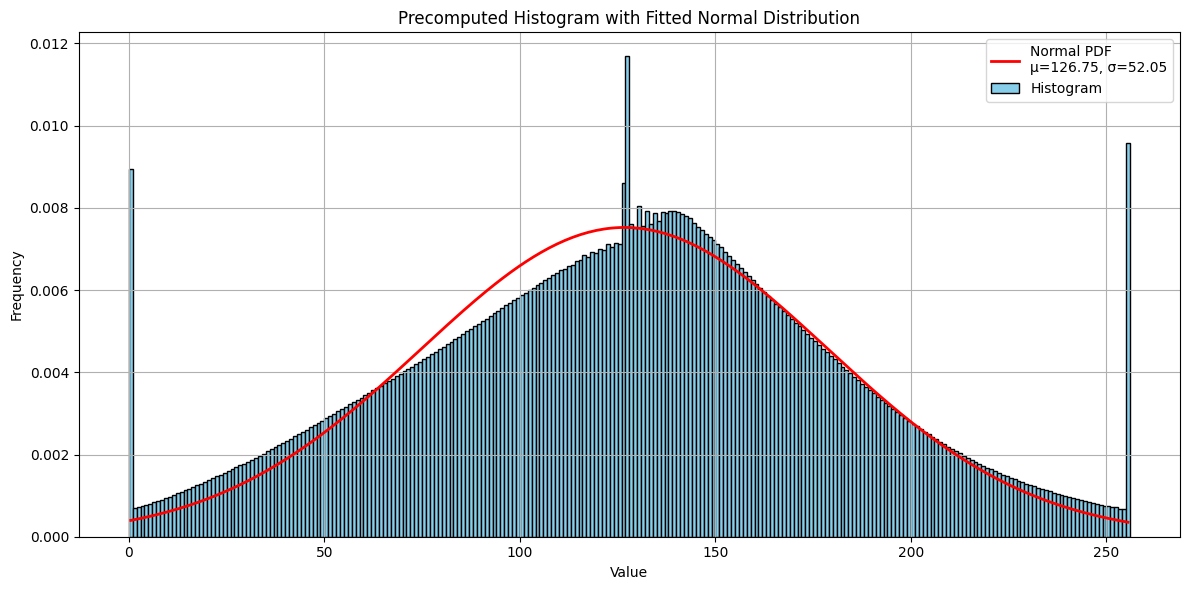

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 🔹 Input: precomputed histogram with 256 bins (replace this with your real data)
hist = accu

# 🔹 Bin centers
bin_edges = np.arange(257)           # 0 to 256
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 0.5 to 255.5

# 🔹 Estimate mean and std from the histogram
total = np.sum(hist[1:-1])
mean = np.sum(hist[1:-1] * bin_centers[1:-1]) / total
variance = np.sum(hist[1:-1] * (bin_centers[1:-1] - mean) ** 2) / total
std = np.sqrt(variance)

# 🔹 Create PDF from estimated normal
pdf = norm.pdf(bin_centers, mean, std)
pdf_scaled = pdf * total * (bin_edges[1] - bin_edges[0])  # scale to histogram

# 🔹 Plot
plt.figure(figsize=(12, 6))
plt.bar(bin_centers, hist, width=1.0, color='skyblue', edgecolor='black', label='Histogram')
plt.plot(bin_centers, pdf_scaled, 'r-', linewidth=2, label=f'Normal PDF\nμ={mean:.2f}, σ={std:.2f}')
plt.title("Precomputed Histogram with Fitted Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

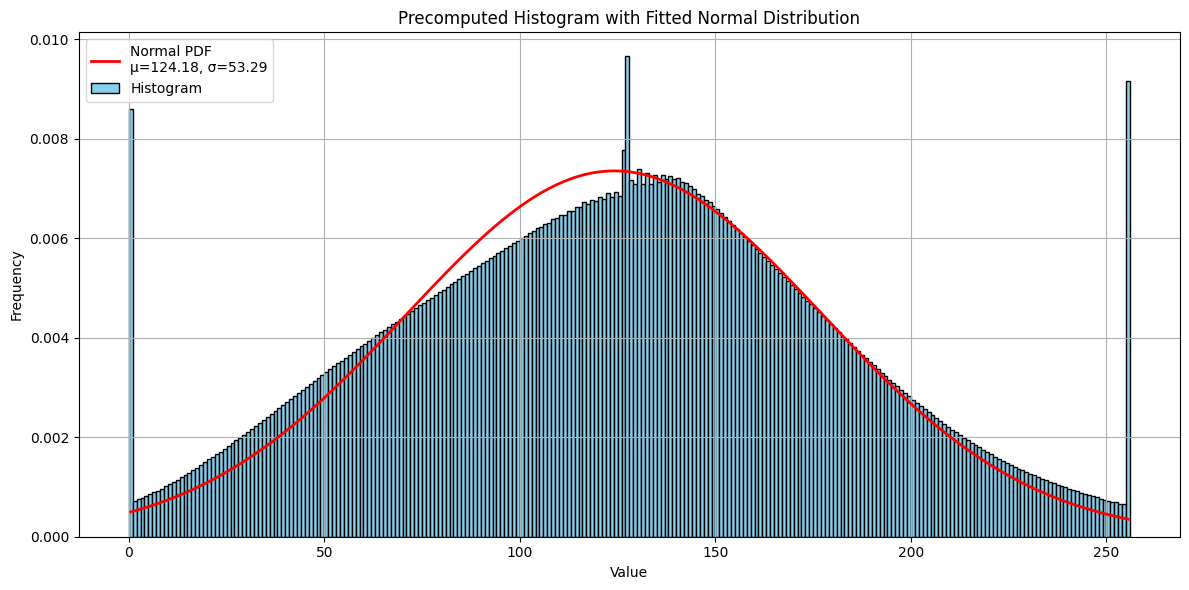

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 🔹 Input: precomputed histogram with 256 bins (replace this with your real data)
hist = avg

# 🔹 Bin centers
bin_edges = np.arange(257)           # 0 to 256
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 0.5 to 255.5

# 🔹 Estimate mean and std from the histogram
total = np.sum(hist[1:-1])
mean = np.sum(hist[1:-1] * bin_centers[1:-1]) / total
variance = np.sum(hist[1:-1] * (bin_centers[1:-1] - mean) ** 2) / total
std = np.sqrt(variance)

# 🔹 Create PDF from estimated normal
pdf = norm.pdf(bin_centers, mean, std)
pdf_scaled = pdf * total * (bin_edges[1] - bin_edges[0])  # scale to histogram

# 🔹 Plot
plt.figure(figsize=(12, 6))
plt.bar(bin_centers, hist, width=1.0, color='skyblue', edgecolor='black', label='Histogram')
plt.plot(bin_centers, pdf_scaled, 'r-', linewidth=2, label=f'Normal PDF\nμ={mean:.2f}, σ={std:.2f}')
plt.title("Precomputed Histogram with Fitted Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
from scipy.special import rel_entr
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn_extra.cluster import KMedoids

In [18]:
K = 4
all_hists.shape

(648, 256)

In [ ]:
# from sklearn.cluster import KMeans

# all_hists = np.array(all_hists)
# kmeans = KMeans(n_clusters=K, init='random', n_init='auto', max_iter=1000, random_state=42)
# labels = kmeans.fit_predict(all_hists)
# centroids = kmeans.cluster_centers_
# labels

In [ ]:
# from sklearn.cluster import KMeans

# reducer = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
# # reducer = PCA(n_components=3)
# reduced = reducer.fit_transform(histograms_norm)
# print(reduced.shape)

# kmeans = KMeans(n_clusters=K, init='random', n_init='auto', max_iter=1000, random_state=42)
# labels = kmeans.fit_predict(reduced)
# # centroids = kmeans.cluster_centers_
# centroids = []
# for cluster_idx in range(K):
#     cluster_hist = all_hists[labels == cluster_idx].mean(axis = 0)
#     centroids.append(cluster_hist)
# labels

In [19]:
def chi2_distance(p, q, eps=1e-10):
    p = np.asarray(p)
    q = np.asarray(q)
    return 0.5 * np.sum((p - q)**2 / (p + q + eps))


def sym_kl(p, q, eps=1e-10):
    p = np.asarray(p) + eps
    q = np.asarray(q) + eps
    kl1 = np.sum(p * np.log(p / q))
    kl2 = np.sum(q * np.log(q / p))
    return 0.5 * (kl1 + kl2)


def ks_distance(p, q):
    cdf1 = np.cumsum(p) / np.sum(p)
    cdf2 = np.cumsum(q) / np.sum(q)
    return np.max(np.abs(cdf1 - cdf2))
    

# Choose a distance metric:
distance_matrix = pairwise_distances(all_hists, metric=sym_kl)  # or sym_kl / ks_distance

# Clustering with KMedoids
kmedoids = KMedoids(n_clusters=K, metric='precomputed', random_state=42)
kmedoids.fit(distance_matrix)

labels = kmedoids.labels_
medoid_indices = kmedoids.medoid_indices_
centroids = all_hists[medoid_indices]
labels

array([0, 0, 0, 3, 0, 2, 2, 3, 0, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 1, 0, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 0, 3, 3, 0, 3, 2, 2,
       3, 2, 2, 0, 0, 0, 0, 3, 0, 2, 0, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3,
       0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 3, 2, 3, 0, 3, 2, 3, 0, 2, 2,
       2, 0, 2, 2, 1, 2, 0, 3, 2, 2, 2, 3, 2, 0, 3, 3, 0, 3, 2, 3, 2, 3,
       3, 2, 3, 2, 2, 0, 3, 2, 2, 3, 3, 2, 2, 0, 3, 2, 2, 2, 2, 3, 3, 3,
       0, 3, 3, 2, 2, 2, 3, 3, 1, 0, 0, 2, 3, 2, 2, 0, 1, 2, 0, 3, 3, 2,
       1, 3, 2, 2, 0, 3, 3, 3, 2, 0, 2, 0, 2, 0, 3, 3, 2, 0, 3, 2, 3, 2,
       2, 3, 2, 0, 2, 3, 2, 3, 3, 3, 3, 0, 2, 3, 0, 0, 2, 2, 2, 0, 2, 0,
       2, 3, 2, 2, 0, 3, 2, 3, 2, 3, 2, 2, 2, 0, 2, 2, 2, 3, 3, 2, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 2, 2, 3, 2, 2, 3, 0, 3, 3,
       3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 1, 0, 3, 2, 0, 2, 3, 3, 3,
       2, 0, 2, 0, 1, 2, 1, 2, 3, 2, 2, 3, 1, 2, 2, 3, 0, 2, 3, 2, 3, 3,
       0, 0, 0, 3, 3, 2, 0, 0, 3, 2, 3, 3, 2, 2, 0,

In [ ]:
# def kl_divergence(p, q):
#     """Compute the KL divergence between two probability distributions."""
#     p = np.asarray(p, dtype=np.float64)
#     q = np.asarray(q, dtype=np.float64)

#     # Normalize to probability distributions
#     p /= np.sum(p)
#     q /= np.sum(q)

#     # Add epsilon to avoid log(0)
#     epsilon = 1e-10
#     p = np.clip(p, epsilon, 1)
#     q = np.clip(q, epsilon, 1)

#     return np.sum(rel_entr(p, q))  # KL(P || Q)


# def ks_distance(hist1, hist2):
#     """Compute KS statistic between two histograms."""
#     cdf1 = np.cumsum(hist1) / np.sum(hist1)
#     cdf2 = np.cumsum(hist2) / np.sum(hist2)
#     return np.max(np.abs(cdf1 - cdf2))  # Equivalent to ks_2samp's D-statistic


# def chi2_distance(p, q, epsilon=1e-10):
#     """Compute Chi-Square distance between two histograms."""
#     p = np.asarray(p, dtype=np.float64)
#     q = np.asarray(q, dtype=np.float64)

#     numerator = (p - q) ** 2
#     denominator = p + q + epsilon
#     return 0.5 * np.sum(numerator / denominator)


# def hellinger_distance(p, q):
#     """Compute Hellinger distance between two histograms."""
#     p = np.asarray(p, dtype=np.float64)
#     q = np.asarray(q, dtype=np.float64)

#     # Normalize histograms to sum to 1
#     p /= np.sum(p)
#     q /= np.sum(q)

#     return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))

    

# def kmeans_kl(histograms, k=3, max_iters=100, tol=1e-4, random_state=None):
#     """KMeans clustering using KL divergence."""
#     np.random.seed(random_state)
#     n_samples = len(histograms)

#     # Initialize centroids randomly
#     centroids = shuffle(histograms, random_state=random_state)[:k]

#     for iteration in range(max_iters):
#         clusters = [[] for _ in range(k)]

#         # Assign clusters based on KL divergence
#         for idx, hist in enumerate(histograms):
#             distances = [kl_divergence(hist, centroid) for centroid in centroids]
#             # distances = [ks_distance(hist, centroid) for centroid in centroids]
#             # distances = [chi2_distance(hist, centroid) for centroid in centroids]
#             # distances = [hellinger_distance(hist, centroid) for centroid in centroids]
            
            
#             cluster_idx = np.argmin(distances)
#             clusters[cluster_idx].append(idx)

#         new_centroids = []

#         for cluster in clusters:
#             if not cluster:
#                 # If a cluster is empty, reinitialize its centroid randomly
#                 new_centroids.append(histograms[np.random.randint(n_samples)])
#                 continue

#             # Compute average histogram (mean) as new centroid
#             cluster_hists = np.array([histograms[i] for i in cluster])
#             mean_hist = np.mean(cluster_hists, axis=0)
#             new_centroids.append(mean_hist)

#         # Convergence check
#         centroid_shifts = [kl_divergence(c1, c2) for c1, c2 in zip(centroids, new_centroids)]
#         if all(shift < tol for shift in centroid_shifts):
#             break

#         centroids = new_centroids

#     # Final assignment
#     labels = np.empty(n_samples, dtype=int)
#     for idx, hist in enumerate(histograms):
#         distances = [kl_divergence(hist, centroid) for centroid in centroids]
#         labels[idx] = np.argmin(distances)

#     return labels, centroids

# labels, centroids = kmeans_kl(all_hists, k=K, max_iters=500, tol=1e-5, random_state=42)
# labels

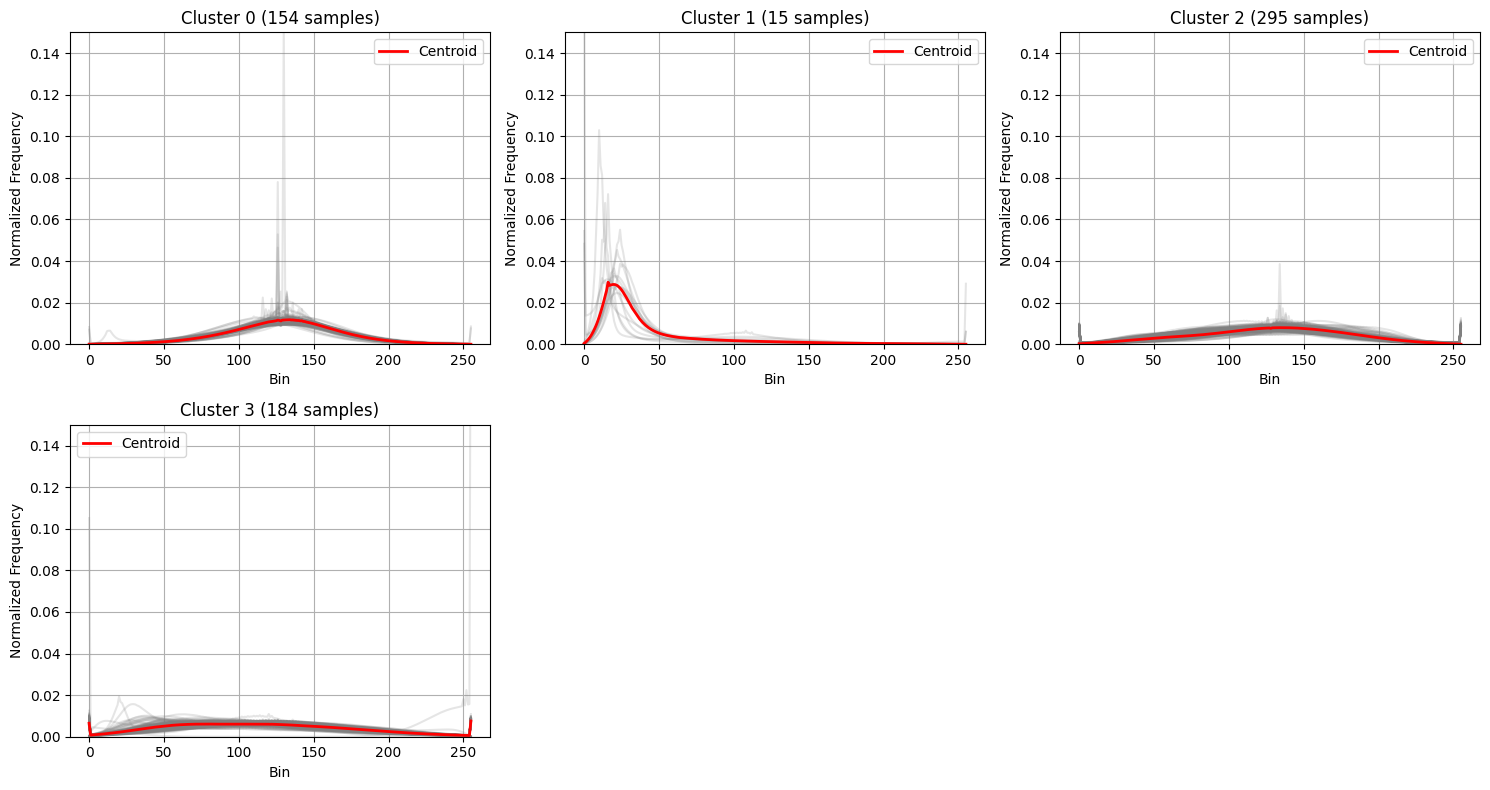

In [20]:
# Step 3: Plot clusters
plt.figure(figsize=(15, 4 * ((K + 2) // 3)))

for k in range(K):
    cluster_histos = all_hists[labels == k]
    plt.subplot((K + 2) // 3, 3, k + 1)

    for h in cluster_histos:
        plt.plot(h, color='gray', alpha=0.2)

    plt.plot(centroids[k], color='red', linewidth=2, label='Centroid')
    plt.title(f'Cluster {k} ({len(cluster_histos)} samples)')
    plt.xlabel('Bin')
    plt.ylabel('Normalized Frequency')
    plt.ylim(0, 0.15)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [21]:
dark = np.where(labels == 1)[0]
(all_hists[dark][:, :50].sum(axis = 1) / all_hists[dark][:, 50:].sum(axis = 1)).min()

1.5758161404737379

In [22]:
(all_hists[~dark][:, :50].sum(axis = 1) / all_hists[~dark][:, 50:].sum(axis = 1)).max()

0.22984729837800635

In [ ]:
(1.5758161404737379 + 0.22984729837800635) / 2

In [39]:
[list(ret.keys())[idx] for idx in np.where(all_hists[:, :50].sum(axis=1) / all_hists[:, 50:].sum(axis = 1) > 0.22)[0]]

['tomo_08bf73',
 'tomo_225d8f',
 'tomo_24a095',
 'tomo_2c9da1',
 'tomo_32aaa7',
 'tomo_37c426',
 'tomo_3a0914',
 'tomo_3a8480',
 'tomo_3b8291',
 'tomo_3b83c7',
 'tomo_423d52',
 'tomo_53e048',
 'tomo_54e1a7',
 'tomo_5b359d',
 'tomo_648adf',
 'tomo_67ff4e',
 'tomo_692081',
 'tomo_6b1fd3',
 'tomo_6c203d',
 'tomo_73173f',
 'tomo_774aae',
 'tomo_7f0184',
 'tomo_7fbc49',
 'tomo_81445c',
 'tomo_918e2b',
 'tomo_93c0b4',
 'tomo_98686a',
 'tomo_9986f0',
 'tomo_9cd09e',
 'tomo_9f424e',
 'tomo_9f918e',
 'tomo_a8bf76',
 'tomo_ac4f0d',
 'tomo_b18127',
 'tomo_bde7f3',
 'tomo_c36baf',
 'tomo_c84b8e',
 'tomo_d0c025',
 'tomo_d8c917',
 'tomo_f672c0']

In [55]:
df.filter(pl.col('tomo_id').is_in(ERR1)).group_by('num_motors').len()

num_motors,len
i64,u32
0,15


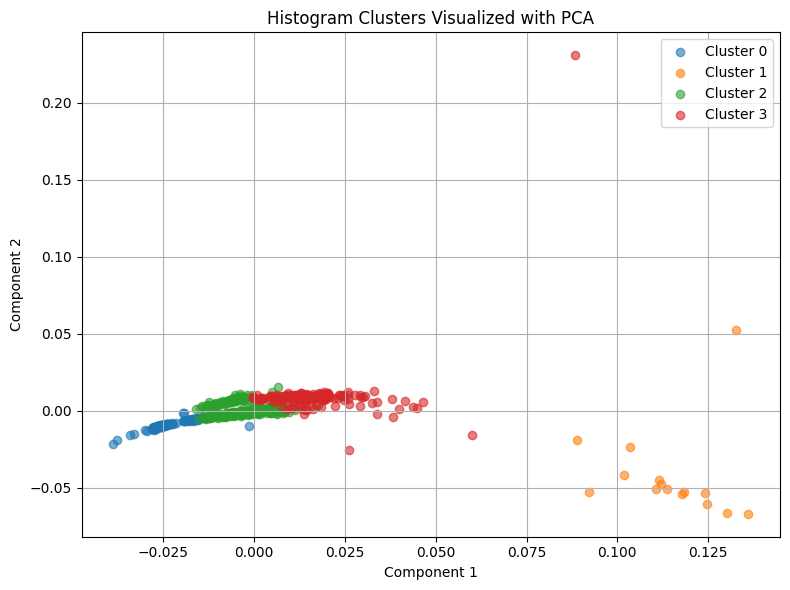

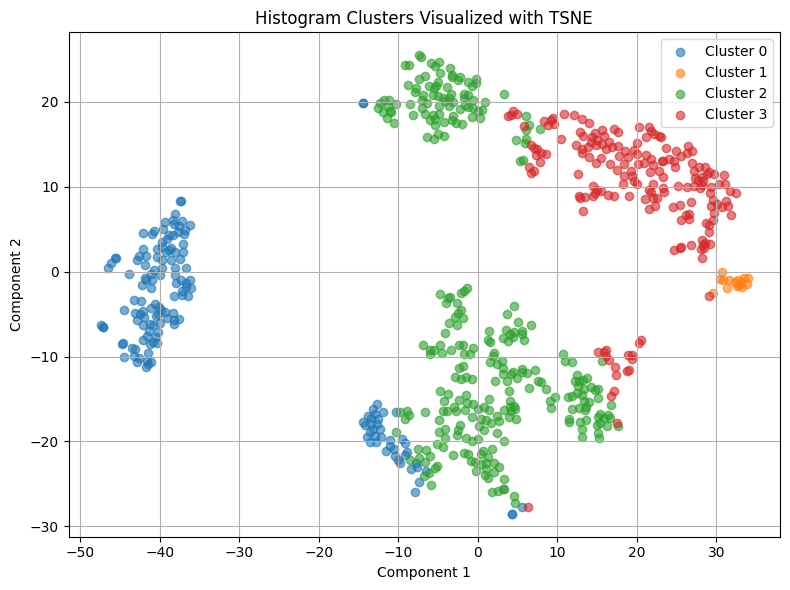

In [23]:
# Step 3: Dimensionality reduction
histograms_norm = all_hists
for method in ['pca', 'tsne']:
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    reduced = reducer.fit_transform(histograms_norm)
    
    # Step 4: Scatter plot
    plt.figure(figsize=(8, 6))
    for k in range(K):
        cluster_points = reduced[labels == k]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k}', alpha=0.6)
    
    plt.title(f"Histogram Clusters Visualized with {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [51]:
ERR2 = sorted([list(ret.keys())[idx] for idx in np.where(labels == 1)[0]])
print(ERR2)

['tomo_08bf73', 'tomo_24a095', 'tomo_37c426', 'tomo_3a0914', 'tomo_3b8291', 'tomo_5b359d', 'tomo_648adf', 'tomo_67ff4e', 'tomo_692081', 'tomo_6b1fd3', 'tomo_774aae', 'tomo_9f918e', 'tomo_ac4f0d', 'tomo_b18127', 'tomo_d8c917']


In [ ]:
ERR1 = sorted([list(ret.keys())[idx] for idx in np.where(all_hists[:, :50].sum(axis=1) / all_hists[:, 50:].sum(axis = 1) > 1.0)[0]])
print(len(ERR1), ERR1)

for tomo_id in ERR1:
    tomo_dir = os.path.join(DATA_DIR, tomo_id)
    slice_names = sorted(os.listdir(tomo_dir), key = lambda x: int(x.split('.')[0].split('_')[1]))
    Z = len(slice_names)
    img = cv2.imread(os.path.join(tomo_dir, slice_names[Z // 2]))
    img2 = img + 127
    viz = np.concatenate([img, img2], axis = 1)
    plt.imshow(viz, cmap='gray')
    plt.show()

In [52]:
ERR1 == ERR2

True

In [ ]:
def plot_cluster(cluster_idx):
    idxs = np.where(labels == cluster_idx)[0]
    vizs = []
    for idx in idxs:
        tomo_id = list(ret.keys())[idx]
        tomo_dir = os.path.join(DATA_DIR, tomo_id)
        norm_hist = all_hists[idx]
        slice_names = sorted(os.listdir(tomo_dir), key = lambda x: int(x.split('.')[0].split('_')[1]))
        Z = len(slice_names)
        img = cv2.imread(os.path.join(tomo_dir, slice_names[Z // 2]))
        # img_inv = 255 - img
        
        # viz = np.concatenate([img, img_inv], axis = 1)
        viz = img.astype(np.uint8) + 127
        # viz = 255 - img
        
        # plt.imshow(viz, cmap='gray')
        # plt.title(f'{tomo_id}')
        # plt.axis('off')  # hide axis ticks
        # plt.plot(norm_hist)
        # plt.show()
        if len(vizs) >= 50:
            break
        vizs.append(viz)

    num_imgs = len(vizs)
    cols = 5
    rows = num_imgs // cols
    rows = rows + 1 if rows % 5 != 0 else rows
    fig, axes = plt.subplots(rows, cols, figsize=(12, 14))
    axes = axes.flatten()

    for i in range(rows * cols):
        ax = axes[i]
        if i < len(vizs):
            ax.imshow(vizs[i], cmap='gray')
        ax.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

for cluster_idx in range(K):
    print('\n\n\n------------------------------------')
    print('CLUSTER', cluster_idx)
    print('NUM TOMOS:', (labels == cluster_idx).sum())
    plot_cluster(cluster_idx)
    print('\n\n\n------------------------------------')

## DINOv2

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image

# Load DINOv2 ViT model (small/large/giant — here we use 'vitb' = base)
dinov2_vitg14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg_lc')
dinov2_vitg14_reg_lc.eval().cuda()
model = dinov2_vitg14_reg_lc

In [ ]:
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

In [ ]:
def extract_embedding(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).cuda()  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    return embedding.squeeze(0)  # Shape: [dimension]

In [ ]:
all_embeds = []
for tomo_id in tqdm(list(ret.keys())):
    tomo_dir = os.path.join(DATA_DIR, tomo_id)
    slice_names = sorted(os.listdir(tomo_dir), key = lambda x: int(x.split('.')[0].split('_')[1]))
    Z = len(slice_names)
    embed = extract_embedding(os.path.join(tomo_dir, slice_names[Z // 2]))
    print(embed.shape)
    all_embeds.append(embed)

In [ ]:
all_embeds = torch.stack(all_embeds, axis = 0)
all_embeds.shape

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np

# Assume `embeddings` is an (N, D) matrix of image embeddings
# Normalize each vector to unit length
embeddings_normalized = normalize(all_embeds.cpu().numpy(), norm='l2')

# Now you can use regular KMeans
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(embeddings_normalized)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
labels

In [ ]:
# Step 3: Dimensionality reduction
histograms_norm = embeddings_normalized
for method in ['pca', 'tsne']:
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    reduced = reducer.fit_transform(histograms_norm)
    
    # Step 4: Scatter plot
    plt.figure(figsize=(8, 6))
    for k in range(K):
        cluster_points = reduced[labels == k]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k}', alpha=0.6)
    
    plt.title(f"Histogram Clusters Visualized with {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_cluster(cluster_idx):
    idxs = np.where(labels == cluster_idx)[0]
    vizs = []
    for idx in idxs:
        tomo_id = list(ret.keys())[idx]
        tomo_dir = os.path.join(DATA_DIR, tomo_id)
        norm_hist = all_hists[idx]
        slice_names = sorted(os.listdir(tomo_dir), key = lambda x: int(x.split('.')[0].split('_')[1]))
        Z = len(slice_names)
        img = cv2.imread(os.path.join(tomo_dir, slice_names[Z // 2]))
        # img_inv = 255 - img
        # viz = np.concatenate([img, img_inv], axis = 1)
        viz = img
        # plt.imshow(viz, cmap='gray')
        # plt.title(f'{tomo_id}')
        # plt.axis('off')  # hide axis ticks
        # plt.plot(norm_hist)
        # plt.show()
        if len(vizs) >= 50:
            break
        vizs.append(viz)

    num_imgs = len(vizs)
    cols = 5
    rows = num_imgs // cols
    rows = rows + 1 if rows % 5 != 0 else rows
    fig, axes = plt.subplots(rows, cols, figsize=(12, 14))
    axes = axes.flatten()

    for i in range(rows * cols):
        ax = axes[i]
        if i < len(vizs):
            ax.imshow(vizs[i], cmap='gray')
        ax.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

for cluster_idx in range(K):
    print('\n\n\n------------------------------------')
    print('CLUSTER', cluster_idx)
    print('NUM TOMOS:', (labels == cluster_idx).sum())
    plot_cluster(cluster_idx)
    print('\n\n\n------------------------------------')